<a href="https://colab.research.google.com/github/JiayingCarrie/Numerical-Model-TCSPC-Raman-Lidar/blob/main/8_7_6_Numerical_model_TCSPC_Raman_Lidar_V4_(H2%26N2_260108%2CCryLaS_10_950m%2C600s%3Bfull)_LOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCSPC Raman Lidar Model Preface

This Google Colaboratory notebook implements a numerical model for **Time-Correlated Single Photon Counting (TCSPC)** signal processing, specifically applied to **Raman Lidar** for the stand-off detection of hydrogen ($H_2$).
Developed by *Charlie Ironside* (*Curtin University*), the model supports the analysis and fitting of experimental data acquired from laboratory prototype TCSPC Raman Lidar systems.

**Key Features and Functionality:**

The notebook provides a detailed framework for simulating a TCSPC Raman Lidar system, incorporating essential physical phenomena and noise sources that influence photon detection and signal interpretation.

**1. Lidar Equation Implementation**

A photon-based form of the Lidar equation is used to model backscattered light, accounting for:

*   Pump laser parameters (wavelength, pulse width, energy, repetition rate)
*   Lidar system parameters (time resolution, integration time, optical filter bandwidth, system efficiency, dark count rate, receiver aperture, range, and channel crosstalk)

**2. Raman and Rayleigh Scattering**

The model distinguishes between Raman scattering (with Stokes shift) and Rayleigh scattering (at the pump wavelength), providing subroutines to calculate the average photon returns for different gas species (e.g., $H_2$, $N_2$, $O_2$) based on their respective scattering cross-sections.

**3. Poissonian Photon Counting Statistics**

Photon detection follows Poissonian statistics, determining the probability of photon counts—or no counts—from the expected number of photons per time bin. This forms the basis for accurate simulation of single-photon events in TCSPC detection.

**4. Noise Source Modeling**

The model incorporates the main sources of detection noise:

*   **Dark Counts** — intrinsic detector noise
*   **Sky Background** — simulated using solar spectral irradiance data to account for ambient light
*   **Crosstalk Effects** - the simulation includes Rayleigh and $H_2O$ Raman crosstalk, modeling photons that leak into the $H_2$ Raman detection channel—an essential correction for accurate hydrogen detection.

**5. Gaussian Gas Plume Simulation**

A built-in **3D Gaussian diffusion model** allows the definition and visualization of hydrogen gas concentration profiles as a function of distance, with adjustable leak rate, anisotropy, and background concentration.

**TCSPC Signal Processing Framework:**

The model simulates both the temporal and statistical aspects of photon detection using a nested structure:

*   **Outer loop** — iterates over laser pulses
*   **Inner loop** — processes photon detection events across distance/time bins

It includes:

*   **Pulse Spread Uncertainty** — Monte-Carlo treatment of temporal jitter due to finite pulse duration
*   **Detector Deadtime** — simulates detector recovery time following a photon event

**Purpose**

This notebook serves as a comprehensive tool for researchers and engineers developing or analyzing **TCSPC Raman Lidar** systems.
It provides a flexible and physically grounded platform for:

*   Understanding photon-counting signal characteristics
*   Optimizing system parameters
*   Fitting and interpreting experimental data for stand-off gas detection

# Section 1 Introduction
---
The purpose of this notebook is to *numerically model Time-Correlated Single Photon Counting (TCSPC)* for a **Raman Lidar system**.

For background and related studies, see for example:
> Long-range, range-resolved detection of H2 using single-photon ‘quantum’ Raman: a condition monitoring tool for long-term storage of nuclear materials, M. Warden, R. Spesyvtsev, E. Kelly, J. Leck, L. McKnight, D. Armstrong, et al. Proc. SPIE PC12116, Chemical, Biological, Radiological, Nuclear, and Explosives (CBRNE) Sensing XXIII, PC1211608 (30 May 2022) 2022

see also:
> "Lidar Engineering: Introduction to Basic Principles,"  G. G. Gimmestad and D. W. Roberts, Cambridge: Cambridge University Press, 2023

**User Input Parameters:**

The program requires the following user-defined inputs to model the Raman Lidar system accurately:

**1. Pump Laser Parameters**

These define the characteristics of the laser source driving the Raman scattering process:

*   **Laser wavelength**[nm]
*   **Laser pulse energy** [µJ]
*   **Laser pulse width** [ns]
*   **Laser repetition rate** [Hz]

**2. Lidar System and Collection Optics Parameters**

These describe the performance and efficiency of the receiver optics and detection system:

*   **Receiver (collection optics) aperture diameter** [cm]
*   **Detector dark count rate** [counts/s]
*   **Lidar constant (K)** — dimensionless (0–1), representing total system efficiency, including optical throughput, detector quantum efficiency, and geometrical overlap
*   **Optical filter bandwidth** [nm]
*   **Crosstalk** — estimate of photon leakage between detection channels

**3. Signal Processing and Timing Parameters**

These parameters define how the TCSPC system records and processes photon events:

*   **Time resolution of the time tagger** [s] — the smallest measurable time interval (e.g., 50 ps); corresponds to the bin width of the TCSPC histogram
*   **Response time (Instrument Response Function, IRF)** [ps] — temporal spread of the combined laser–detector system
*   **Integration time** [s] — total measurement duration over which photon counts are accumulated
*   **Start distance for photon counting** [m]
*   **Total range to be covered** [m]


**Illustration of TCSPC Raman Lidar Operation**

The figure below schematically illustrates the operation of the **Time-Correlated Single Photon Counting (TCSPC) Raman Lidar** system.

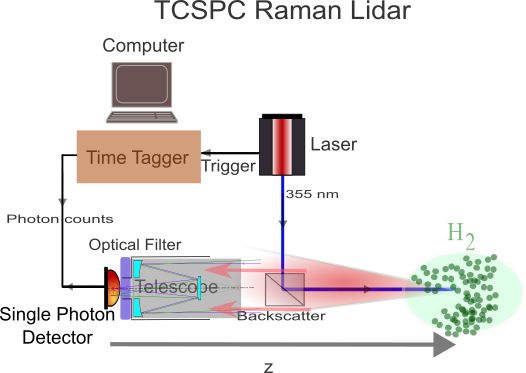

**System Overview**

*   The laser source is a **diode-pumped solid-state (DPSS)**, **frequency-tripled Nd:YAG** laser operating at **355 nm**, producing **1.1 ns** pulses at a repetition rate of **10 kHz** (RepRate = 10,000 Hz).
*   A **synchronization pulse** from the laser triggers the **time tagger** at the initial time $t_0$.
*   The **laser beam** is directed toward the target region.
*   The **backscattered light** is spectrally filtered to **reject Rayleigh scattering** at 355 nm and to **select the Raman Stokes line** corresponding to the gas species of interest.
*   A **single-photon detector** (e.g., PMT or SPAD) generates an electronic pulse upon detecting a returned photon at time $t_r$.
*   The time tagger records the photon arrival time, providing the **time-of-flight (ToF)** between emission and detection: $TOF = t_r - t_0$. Only the **first photon** detected after each laser pulse is recorded, consistent with TCSPC operation.
*   The **next laser pulse** restarts the timing sequence, and a new TOF is measured.
*   The computer accumulates all TOF events into **time bins** of width $t_b$, building a histogram of photon arrivals versus time (or range).
*   This process continues for the **integration period** $T_i$, corresponding to a total of $N = T_i \times RepRate$ laser shots per measurement run.

**Relation Between Time-of-Flight (ToF) and Range**

For a photon scattered from a distance $z$, the time-of-flight is related to range by:

$TOF = t_r - t_0 = 2z / c$

where

*   $c$ — speed of light in air (≈ $3.0\times10^8\ \text{m·s}^{-1}$)
*   The factor of 2 accounts for the **two-way path**: outbound and return travel.

# Section 2 The required Python Packages
---

In [ ]:
# ----------------------------
# Raman Lidar TCSPC Simulation (Vectorized First-Hit TCSPC)
# ----------------------------
# Reproducibility
import random
import numpy as np
random.seed(1234)
np.random.seed(1234)

# Packages
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy import constants
from numba import njit

# Fundamental constants
h = constants.Planck  # in J⋅s
Pi = constants.pi
c = constants.speed_of_light  # in m/s

# Section 3 Lidar Model modified for TCSPC
---


## Lidar Equation (Photon)

**The photon version of the lidar equation for backscattered light**

The number of returned backscattered photons in a Raman channel at wavelength $\lambda_R$ depends on the LIDAR equation as follows:

$P_B(z)=\frac{P_pK_1\Delta z A_0(d\sigma/d\Omega)N}{z^2}\times T_{\lambda_p}(z)\times T_{\lambda_R}(z)\times \gamma(z)$

where

*   $P_B(z)$ - backscattered photons
*   $P_p$ - number of pump photons per pulse
*   $z$ - range, the distance of the receiving optics to the region of interest
*   $K_1$ - LIDAR Constant
*   $\Delta z$ - spatial extent of the sampled region, this is $\Delta z= P_w \times c$ where $P_w$ is the laser pulse width
*   $A_0$ - area cross-section of the collection optics aperture
*   $(d\sigma/d\Omega)$ - Raman scattering cross section
*   $N$ - molecular concentration
*   $T_{\lambda_p}$ - range (z) dependent transmission through the atmosphere at the pump wavelength
*   $T_{\lambda_R}$ - range (z) dependent transmission through the atmosphere at the Raman wavelength
*   $\gamma(z)$ - range (z) dependent overlap function between the laser and receiver fields of view

## Model Flowchart

The Raman LIDAR TCSPC model is implemented in Python within a Jupyter Notebook environment. The structure of the model reflects the physical processes involved in Raman backscattering and detection, consisting
of three main components: $H_2$ gas, $H_2$ signal, and noise, followed by a Monte-Carlo photon-counting simulation.

The flowchart of the model is shown below:

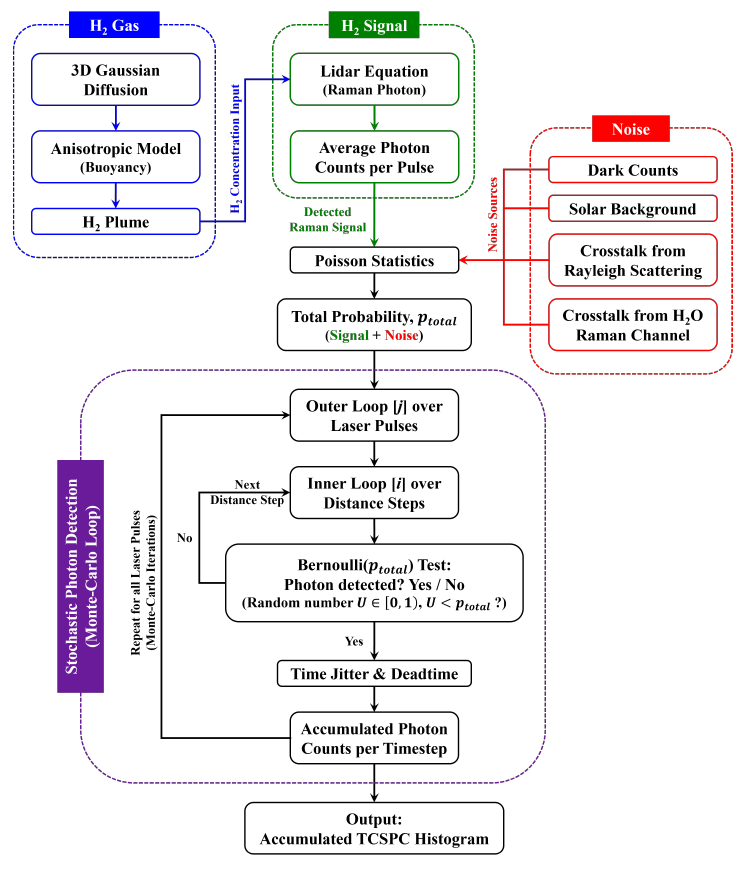

# Section 4  TCSPC and Time of Flight (ToF) Raman Lidar
---


**The key parameters for $H_2$ sensing with Raman LIDAR scattering are:**

*   $H_{2}$ Raman scattering cross section $(d\sigma/d\Omega)_H=7.07 \times 10^{-30} cm^2sr^{-1} @ 355~nm$ Stokes shift 4160.2 $cm^{-1}$
*   $N_2$ Raman scattering cross section $(d\sigma/d\Omega)_N=2.28 \times 10^{-30} cm^2sr^{-1} @ 355~nm$ Stokes shift 2330.7 $cm^{-1}$
*   $H_2O$ Raman scattering cross-section $(d\sigma/d\Omega)_O = 6.34 \times 10^{-30} cm^2sr^{-1} @355nm$ Stokes shift 3651.7 $cm^{-1}$

These values derived from
> Raman Xsection - Industrial Applications of Laser Remote Sensing, Chapter 4: Gas Sensing Using Raman Scattering, H. Ninomija, 2012 (pp. 64-65, Table 1)

If both $H_2$ and $N_2$ Raman lines are measured simultaneously, then the concentration of $H_2$ molecules can be calibrated against the known concentration of $N_2$ molecules in air. Here we outline the calibration procedure. If the $H_2$ Raman channel has photon counts $P_{H_2}$ and the $N_2$ Raman channel has photon counts $P_{N_2}$ then the $H_2$ molar concentration in air, $Air_{H_2}$, can be calculated from:

$Air_{H_2} = Air_{N_2} \times \frac{N_{H_2}}{N_{N_2}} = Air_{N_2} \times \frac{P_{H_2}}{P_{N_2}} \times \frac{(d\sigma/d\Omega)_{N_2}}{(d\sigma/d\Omega)_{H_2}} \times \frac{K_{N_2}}{K_{H_2}} \times \frac{T_{\lambda_{N_2}}}{T_{\lambda_{H_2}}} \times \gamma(z)$

where

*   $Air_{N_2}$ - fraction of $N_2$ in air, around 0.78
*   $N_{H_2}$, $N_{N_2}$ - number densities of $H_2$ and $N_2$ molecules
*   ${P_{H_2}}$, ${P_{N_2}}$ - backscattered photons for $H_2$ and $N_2$
*   $(d\sigma/d\Omega)_{H_2}$, $(d\sigma/d\Omega)_{N_2}$ - Raman cross sections for $H_2$ and $N_2$
*   ${K_{H_2}}$, ${K_{N_2}}$ - LIDAR constants for $H_2$ and $N_2$
*   $T_{\lambda_{H_2}}$, $T_{\lambda_{N_2}}$ - transmissions through the atmosphere at the Raman wavelength of $H_2$ and $N_2$
*   $\gamma(z)$ - range (z) dependent overlap function between the laser and receiver fields of view

To address these factors in a streamlined manner, they can be integrated into a calibration constant, denoted as $K$, as described by the following equation:

$Air_{H_2} = K \times\frac{P_{H_2}}{P_{N_2}}$

The calibration constant $K$ is a singular value that amalgamates all the fixed physical constants($Air_{N_2}$, $(d\sigma/d\Omega)_{H_2}$,$(d\sigma/d\Omega)_{N_2}$) and characteristics of the system ($K_{H_2}$, $K_{N_2}$, $T_{\lambda_{H_2}}$, $T_{\lambda_{N_2}}$, $\gamma(z)$). The $K$ value is empirically derived by directing the dual-channel Raman LIDAR towards a known concentration of $H_2$, which is quantified by means of, for example, an electro-chemical sensor.

### Raman Lidar function

In [ ]:
# --------------------------
# Raman Lidar function – excluding UV transmission & geometrical overlap
# --------------------------
def Raman_Lidar(Pump_Lambda_nm, Pulse_FWHM_s, Pump_photons,
                Ramanxsection_cm2_sr, RamanStokes_cm1, Distance_m,
                Lidarconstant, Gas_percent, Receiver_diameter_cm):
  """
  Compute the MEAN number of Raman photons returned in one time bin (per pulse).
  Implements the photon-counting lidar equation in photon units.

  Includes (λ_S / λ_P) factor because output is in photons, not energy.

  Inputs:
    Pump_Lambda_nm       - nm, pump wavelength
    Pulse_FWHM_s         - s, laser pulse width (FWHM)
    Pump_photons         - photons per pump pulse
    Ramanxsection_cm2_sr - cm² sr⁻¹, Raman scattering cross-section at pump wavelength
    RamanStokes_cm1      - cm⁻¹, Raman Stokes shift (wavenumbers)
    Distance_m           - m, range to scatterers
    Lidarconstant        - [0,1], overall system efficiency (optics, detector QE, overlap, etc.)
    Gas_percent          - %, target gas concentration
    Receiver_diameter_cm - cm, receiver diameter

  Output:
    Raman_photons        - mean Raman photons per bin (NO atmospheric transmission & NO geometrical overlap)
  """

  # Raman photon wavelength
  Pump_Wavenumber_cm1 = 1/(Pump_Lambda_nm*1e-7)                        # cm⁻¹
  Raman_Wavelength_nm = 1/(Pump_Wavenumber_cm1 - RamanStokes_cm1)*1e7  # nm

  # Distance and pulse length
  Distance_cm = max(Distance_m*100, 1e-9)  # cm, avoid divide-by-zero
  Pulse_length_cm = Pulse_FWHM_s*c*100    # cm, spatial length of pulse (Δz)

  # Number density of scatterers (cm⁻³) scaled by % concentration (Loschmidt constant, see https://en.wikipedia.org/wiki/Loschmidt_constant)
  NumberDensity_cm3 = 2.686e19 * Gas_percent/100  # cm⁻³, number of molecules per unit volume

  # Receiver area (cm²)
  Receiver_area_cm2 = Pi*(Receiver_diameter_cm/2)**2

  # Raman lidar equation (photon form)
  Raman_photons = (
      Pump_photons * Lidarconstant * Pulse_length_cm * Receiver_area_cm2 *
      Ramanxsection_cm2_sr * NumberDensity_cm3 / (Distance_cm**2)
      * (Raman_Wavelength_nm / Pump_Lambda_nm)
  )
  return Raman_photons

## UV Transmission

From LIDAR equation:
*   $T_{\lambda_p}$ - range (z) dependent transmission through the atmosphere at the pump wavelength
*   $T_{\lambda_R}$ - range (z) dependent transmission through the atmosphere at the Raman wavelength

Calculates $T_{\lambda_p}$ and $T_{\lambda_R}$, data from:
> W. A. Baum, "Attenuation of Ultraviolet Light by the Lower Atmosphere," California Institute of Technology, 1950. [Online].

> Available: https://resolver.caltech.edu/CaltechETD:etd-08272008-082651

The relationship between attenuation and transmission is given by the **Beer–Lambert law**:

$T(L) = e^{-\alpha L}$

where

*   $T(L)$ - fractional transmission after traveling distance $L$
*   $\alpha$ - attenuation coefficient [km⁻¹]
*   $L$ - path length [km]

### Spectrum Data

**Good Day Data**

In [ ]:
# --------------------------
# UV transmission spectrum - good day
# --------------------------
# URL to solar spectrum file on Dropbox
URL_UVT1 ='https://www.dropbox.com/scl/fi/6zs6xdtaq9jihfc5j2jh0/UV-transmission.csv?rlkey=ffxbz36y9k8vh3qqt9frn8lkd&raw=1'  # good day, remember to replace dl=0 with raw=1

# Read CSV, skip first row (header info)
UV_transmission = pd.read_csv(URL_UVT1)  # good day

# Preview first rows
UV_transmission.head()

,x nm,y km-1
0,233.720930,3.992308
1,239.147287,2.915385
2,244.573643,1.861538
3,249.224806,1.515385
4,255.038760,1.246154


### Fuction

In [ ]:
# --------------------------
# UV transmission function
# --------------------------
def uv_transmission(wavelength_nm, Distance_m):
    """
    Interpolates the UV transmission curve at a given wavelength, then scales it to the actual path length (distance_m).

    The CSV (UV_transmission) columns:
      [0]: Wavelength [nm]
      [1]: Attenuation coefficient α [km⁻¹]

    Inputs:
      wavelength_nm - nm, wavelength of interest
      Distance_m    - m, path length through atmosphere

    Output:
      transmission  - [0–1], fractional transmission at this wavelength and distance
    """

    # Extract wavelength and attenuation coefficient from the CSV
    wl = UV_transmission.iloc[:, 0].values.astype(float)           # nm
    alpha_perkm = UV_transmission.iloc[:, 1].values.astype(float)  # attenuation coefficient [km⁻¹]

    # Convert attenuation coefficient (α) to fractional transmission per km
    T_perkm = np.exp(-alpha_perkm)  # Beer–Lambert law, transmission per km: T_perkm = exp(-α)

    # Handle out-of-range wavelengths by clamping
    if wavelength_nm <= wl.min():
        T_here = T_perkm[0]       # use the lowest available transmission
    elif wavelength_nm >= wl.max():
        T_here = T_perkm[-1]      # use the highest available transmission
    else:
        # Linear interpolation between two bracketing data points
        idx = np.searchsorted(wl, wavelength_nm) - 1
        idx = np.clip(idx, 0, len(wl) - 2)  # keep index in valid range
        frac = (wavelength_nm - wl[idx]) / (wl[idx + 1] - wl[idx])  # fractional distance between points
        T_here = T_perkm[idx] * (1 - frac) + T_perkm[idx + 1] * frac  # linear blend

    # Scale transmission to actual path length
    transmission = T_here ** (Distance_m / 1000.0)  # transmission over distance_m: T = (T_perkm)^(distance_m/km)

    return transmission

## Geometrical Overlap

From LIDAR equation:
*   $\gamma(z)$ - range (z) dependent overlap function between the laser and receiver fields of view

AI written code see:
> https://g.co/gemini/share/7cb10e841429

> https://g.co/gemini/share/b5749a672e9b

The overlap function $\gamma(z)$ describes how well the laser beam and the receiver telescope’s field of view (FOV) overlap as a function of range $z$.

The normalized **overlap factor** $\gamma(z)$ is simply the fraction of the laser beam area that lies within the receiver’s FOV at range $z$:

$\gamma(z) = \frac{A_{\text{intersect}}}{\pi r_1^2}$

where

*   $A_{\text{intersect}}$ - intersection area between the laser beam and the receiver FOV
*   $r_1$ - laser beam radius at range $z$, this is $r_1 = w_0 + z \times \theta_t$ where $w_0$ is the laser beam radius at aperture, $\theta_t$ is the half-angle beam divergence

**Piecewise definition of intersection area:**

*   No overlap ⇒ circles are separate, area = 0
*   FOV inside laser ⇒ intersection = FOV area
*   Laser inside FOV ⇒ intersection = laser area
*   Partial overlap ⇒ intersection given by the full formula with $arccos$ and the square-root term

The **intersection area** $A_{\text{intersect}}$ between the laser beam and the receiver field of view (FOV) is given by:

$A_{\text{intersect}}$ =
\begin{cases}
0, & d_{eff} \geq r_1 + r_2 \quad \text{(no overlap)} \\[8pt]
\pi r_2^2, & d_{eff} \leq |r_1 - r_2|, \; r_2 \text{ inside } r_1 \\[8pt]
\pi r_1^2, & d_{eff} \leq |r_2 - r_1|, \; r_1 \text{ inside } r_2 \\[12pt]
r_1^2 \arccos\!\left(\frac{d_{eff}^2 + r_1^2 - r_2^2}{2 d_{eff} r_1}\right)
+ r_2^2 \arccos\!\left(\frac{d_{eff}^2 + r_2^2 - r_1^2}{2 d_{eff} r_2}\right)
- \tfrac{1}{2} \sqrt{(-d_{eff} + r_1 + r_2)(d_{eff} + r_1 - r_2)(d_{eff} - r_1 + r_2)(d_{eff} + r_1 + r_2)},
& \text{otherwise (partial overlap).}
\end{cases}

where

*   $r_2$ - receiver FOV radius at range $z$, this is $r_2 = z \times \theta_{\text{rec}}$ where $\theta_{\text{rec}}$ is the half-angle receiver FOV
*   $d_{eff}$ - effective separation between the laser and receiver axes

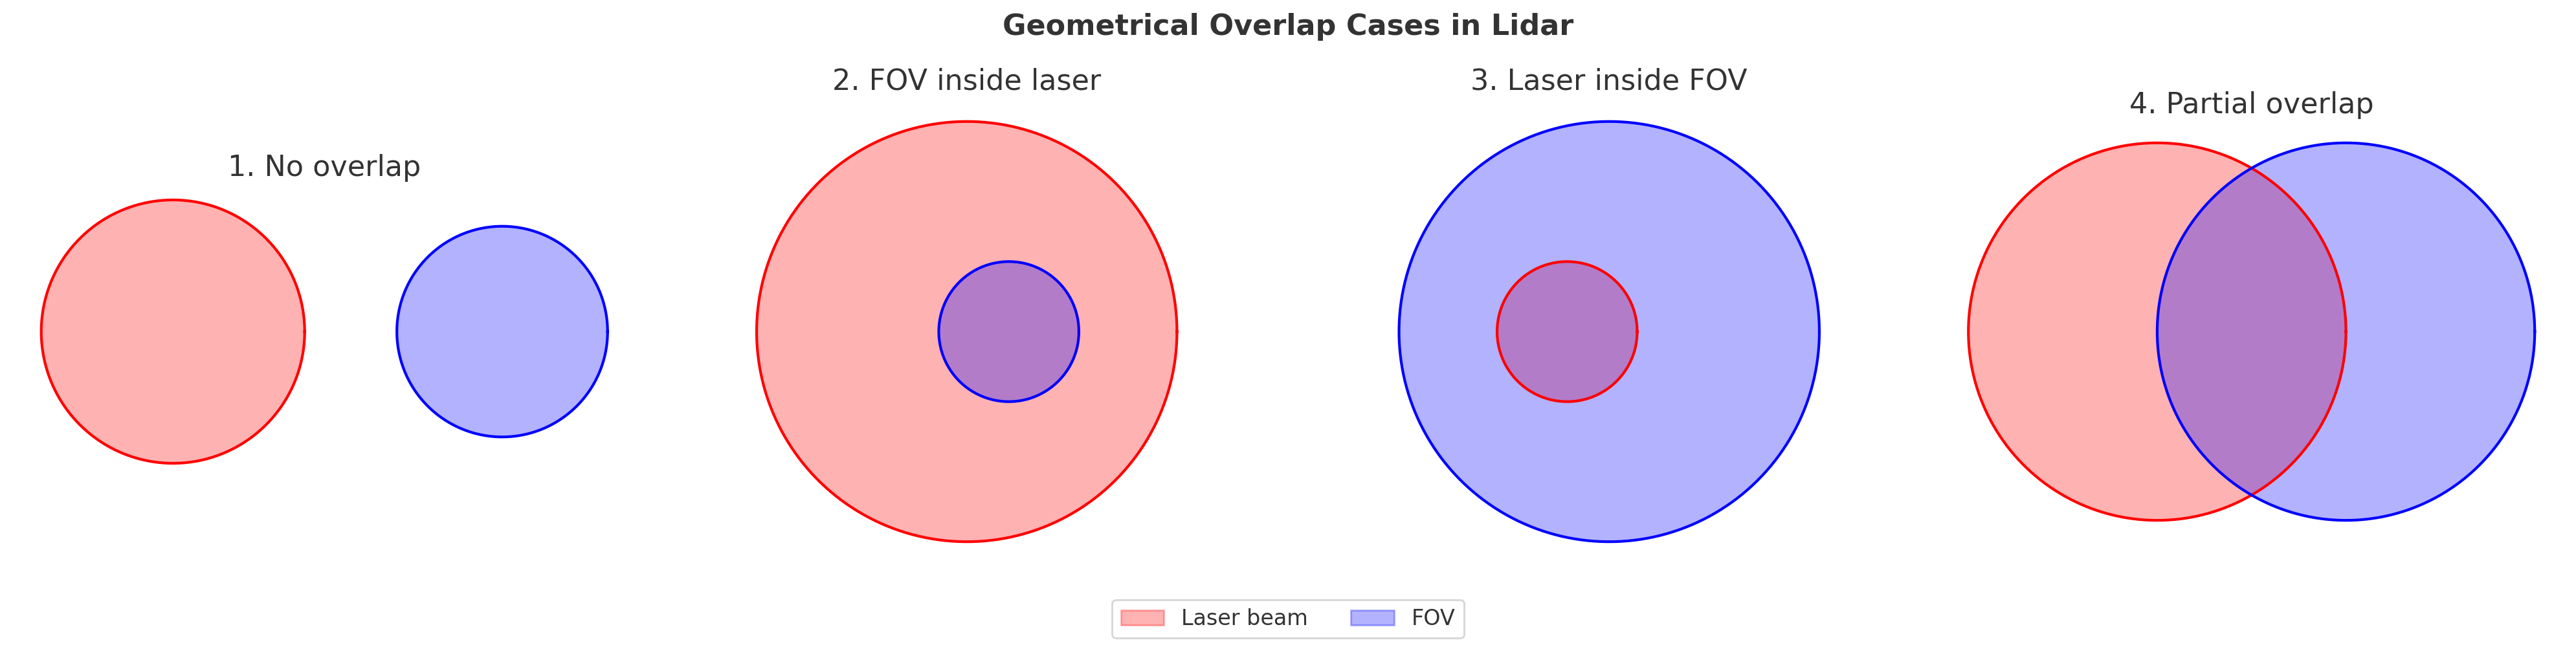

Here’s a diagram showing the partial overlap case of the formula:

*   The **blue circle** is the laser beam radius $r_1$
*   The **green circle** is the receiver FOV radius $r_2$
*   The **orange shaded region** is the **intersection area** $A_{\text{intersect}}$
*   The two red points $P_1$, $P_2$ are the circle–circle intersection points
*   The dashed black triangle ($C_1$, $C_2$, $P_1$) illustrates the geometry used in the formula (involving the arccos terms and the square-root Heron term)

**Effective separation between the laser and receiver axes ($d_{eff}$):**

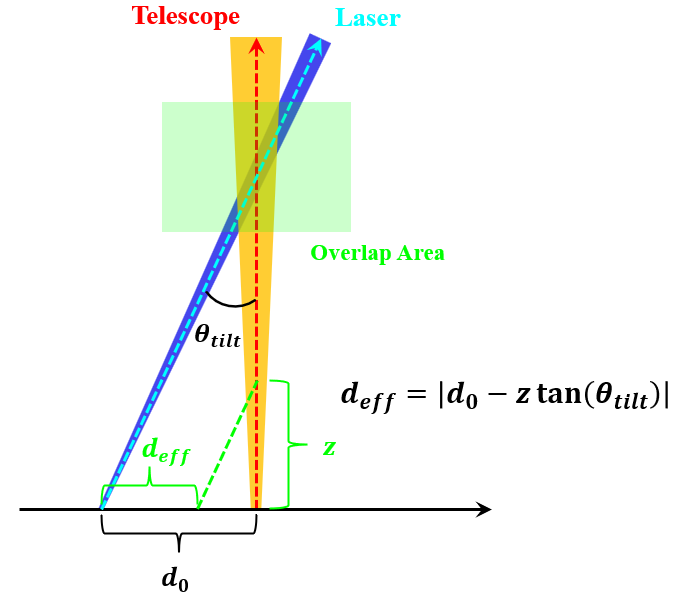

### Fuction

In [ ]:
# --------------------------
# Geometrical overlap function (tilt)
# --------------------------
def calculate_overlap_factor(z, d0, w0, theta_t, theta_rec, theta_tilt):
    """
    Calculates geometrical LIDAR overlap factor γ(z) ∈ [0,1].
    This models the fraction of the laser beam that overlaps with the receiver field of view (FOV) in a biaxial lidar geometry.

    Inputs:
        z          - m, ranges at which to evaluate the overlap
        d0         - m, initial separation distance between laser and telescope axes (at z=0)
        w0         - m, laser beam radius at aperture (at z=0)
        theta_t    - rad, half-angle beam divergence
        theta_rec  - rad, half-angle receiver FOV
        theta_tilt - rad, tilt angle between laser and telescope axes

    Outputs:
        Overlap factor at each range, values between 0 (no overlap) and 1 (full overlap).
    """

    # --- Calculate beam and receiver radii ---
    # Laser beam radius: w0 + z * tan(theta_t) ≈ w0 + z * theta_t for small angles
    r_laser = w0 + z * theta_t

    # Receiver FOV radius: z * tan(theta_rec) ≈ z * theta_rec for small angles
    r_fov = z * theta_rec

    # --- Effective separation due to tilt ---
    # Axes separation changes linearly with z depending on tilt direction
    d_eff = np.abs(d0 - z * np.tan(theta_tilt))  # Effective separation

    # --- Laser cross-section area ---
    A_laser = np.pi * r_laser**2
    A_laser[A_laser == 0] = 1e-9  # Avoid division by zero

    # --- Prepare geometric parameters for intersection calculation ---
    r1, r2 = r_laser, r_fov
    d_sq, r1_sq, r2_sq = d_eff**2, r1**2, r2**2

    # --- Safe arccos arguments for circle intersection ---
    arg1_denom = 2 * d_eff * r1
    arg2_denom = 2 * d_eff * r2

    arg1 = np.ones_like(arg1_denom)
    arg2 = np.ones_like(arg2_denom)

    mask1 = arg1_denom > 0
    mask2 = arg2_denom > 0
    mask1[d_eff == 0] = False
    mask2[d_eff == 0] = False

    arg1[mask1] = np.clip((d_sq[mask1] + r1_sq[mask1] - r2_sq[mask1]) / arg1_denom[mask1], -1, 1)
    arg2[mask2] = np.clip((d_sq[mask2] + r2_sq[mask2] - r1_sq[mask2]) / arg2_denom[mask2], -1, 1)

    # --- Common square-root term ---
    sqrt_term_val = (-d_eff + r1 + r2) * (d_eff + r1 - r2) * (d_eff - r1 + r2) * (d_eff + r1 + r2)
    sqrt_term = np.sqrt(np.maximum(0, sqrt_term_val))

    # --- Partial-overlap case ---
    A_partial = r1_sq * np.arccos(arg1) + r2_sq * np.arccos(arg2) - 0.5 * sqrt_term

    # --- Piecewise definition for all geometric configurations ---
    A_intersect = np.where(
        d_eff >= r1 + r2,  # No overlap
        0.0,
        np.where(
            d_eff <= r1 - r2,  # Receiver inside laser beam
            np.pi * r2_sq,
            np.where(
                d_eff <= r2 - r1,  # Laser inside receiver FOV
                np.pi * r1_sq,
                A_partial           # Partial overlap
            )
        )
    )

    # --- Normalized overlap factor ---
    overlap_factor = A_intersect / A_laser

    return overlap_factor

# Section 5 Noise Sources
---

**Noise Sources**

*   Dark Counts
*   Solar Background (not included in this case, indoor experiment: set as 0)
*   Crosstalk from Rayleigh Scattering
*   Crosstalk from Water Vapor Raman Channel

**Poisson Statistics**

To get the probability of zero photons, $P_0$, from the average number of photons in returned from a pulse, $P_A$, we use the Poisson distribution. This assumption is used for Raman scattering, Rayleigh scattering, noise sources, and dark counts.

$P(k) = \frac{P_A^k e^{-P_A}}{k!}$

for $k=0$ this simplifies to $P_0 = e^{-P_A}$

## Dark Counts

Darkcount is part of the single photon counter specification.

### Fuction

In [ ]:
# --------------------------
# Dark counts function
# --------------------------
def Darkcount(Countrate, DeltaT):
  """
  Computes the probability of detecting at least one dark count within a given time interval (Δt), assuming Poisson statistics.

  Inputs:
    Countrate  - counts/s, photon detector dark count rate (cps)
    DeltaT     - s, duration of the detection window or averaging interval

  Output:
    prob_count - [0–1], probability of ≥1 dark count in Δt
  """

  darkcount = Countrate*DeltaT  # expected number of dark counts in the time window
  prob_zero = poisson.pmf(0, darkcount)  # Poisson probability of observing 0 dark counts

  return 1 - prob_zero  # probability of ≥1 dark count

## Crosstalk from  Rayleigh Scattering

**The lidar equation can also be used for Rayleigh scattering**, see the book for Rayleigh back-scattering coefficients of $H_2$, $N_2$ and $O_2$:
> Rayleigh Xsection - Laser Remote Sensing Fundamentals and Applications, R. M. Measures, 1992 (p. 43, Table 2.3)

For $H_2$ the Rayleigh scattering cross-section is $(d\sigma^R/d\Omega) = 0.44 \times 10^{-28} cm^2sr^{-1} @ 694.3nm$

*   $H_2$ Rayleigh scattering cross-section $(d\sigma^R/d\Omega) = 6.44 \times 10^{-28} cm^2sr^{-1} @355nm$
*   $N_2$ Rayleigh scattering cross-section $(d\sigma^R/d\Omega) = 31.31 \times 10^{-28} cm^2sr^{-1} @355nm$ - 0.78 of total atmosphere
*   $O_2$ Rayleigh scattering cross-section $(d\sigma^R/d\Omega) = 26.34 \times 10^{-28} cm^2sr^{-1} @355nm$ - 0.20 of total atmosphere

The key difference between Raman and Rayleigh Lidar is that Raman backscattering exhibits a Stokes shift in the return signal, whereas Rayleigh backscattering occurs at the same wavelength as the pump laser. Additionally, the Raman scattering coefficients are typically about two orders of magnitude (∼100 times) smaller than those of Rayleigh scattering.

Use **Rayleigh Lidar function**

Cross talk from the Rayleigh channel into the Raman channel can be a source of noise.

We take data on the Rayleigh scattering coefficients from:
> D. R. Bates, "RAYLEIGH-SCATTERING BY AIR," Planetary and Space Science, Note vol. 32, no. 6, pp. 785-790, 1984, doi: 10.1016/0032-0633(84)90102-8.

we read the data for a given Raman pump wavelength.

### Spectrum Data

In [ ]:
# --------------------------
# Rayleigh backscatter spectrum
# --------------------------
# URL to Rayleigh backscatter spectrum file on Dropbox
# D. R. Bates, "RAYLEIGH-SCATTERING BY AIR," Planetary and Space Science, Note vol. 32, no. 6, pp. 785-790, 1984, doi: 10.1016/0032-0633(84)90102-8.
URL_Rayleigh = 'https://www.dropbox.com/scl/fi/rd1nz4c1wnct073aqixgm/Rayleigh-Scattering.csv?rlkey=13h3z6475m8fwznnkjufk8fzz&raw=1'  # Remember to replace dl = 0 with raw = 1

# Read CSV, skip first row (header info)
Rayleigh = pd.read_csv(URL_Rayleigh, skiprows=3)

# Preview first rows
Rayleigh.head()

,Wavelength [nm],Refractive Index(n-1)E4,Scattering coefficent [cm2],Back ScatterCross Section (cm2/sr),Effective King,Refractive index
0,200,3.421,3.620000e-25,4.310000e-26,1.080,1.000342
1,205,3.384,3.200000e-25,3.810000e-26,1.077,1.000338
2,210,3.352,2.840000e-25,3.380000e-26,1.074,1.000335
3,215,3.323,2.540000e-25,3.020000e-26,1.072,1.000332
4,220,3.298,2.270000e-25,2.700000e-26,1.070,1.000330


### Fuctions

In [ ]:
# --------------------------
# Air Rayleigh backscatter function
# --------------------------
def Rayleigh_air(Wavelength_nm):
  """
  Interpolates the Rayleigh backscatter cross-section in cm²/sr for a given wavelength.

  The input CSV (UV_transmission) should have:
    Column 0: Wavelength [nm]
    Column 1: Back Scatter Cross-Section [cm² sr⁻¹]

  Input:
  Wavelength_nm - nm, wavelength of interest

  Output:
  bs            - cm² sr⁻¹, Rayleigh scattering cross-section
  """

  # Extract wavelength and backscatter data from the Rayleigh table
  w = Rayleigh['Wavelength [nm]'].values
  bs = Rayleigh['Back ScatterCross Section (cm2/sr)'].values

  # Clamp the wavelength to the valid range of the dataset
  if Wavelength_nm <= w.min():
      print('Wavelength out of range (low); clamped.')
      return bs[0]
  if Wavelength_nm >= w.max():
      print('Wavelength out of range (high); clamped.')
      return bs[-1]

  # Linear interpolation between two nearest data points
  idx = np.searchsorted(w, Wavelength_nm) - 1
  idx = np.clip(idx, 0, len(w)-2)

  # Compute interpolation fraction
  t = (Wavelength_nm - w[idx])/(w[idx+1] - w[idx])

  return bs[idx]*(1 - t) + bs[idx+1]*t


# --------------------------
# Rayleigh Lidar function - excluding UV transmission & geometrical overlap
# --------------------------
def Rayleigh_Lidar(Pump_Lambda_nm, Pulse_width_s, Pump_photons,
                   Rayleighxsection_cm2_sr, Distance_m,
                   Lidarconstant, Gas_percent, Receiver_diameter_cm):
  """
  Compute mean Rayleigh photons returned in one time bin. Similar to Raman, but no (λS / λP) factor.

  Inputs:
    Pump_Lambda_nm          - nm, pump wavelength
    Pulse_width_s           - s, laser pulse width
    Pump_photons            - Photons in pump pulse
    Rayleighxsection_cm2_sr - cm² sr⁻¹, Rayleigh scattering cross-section at pump wavelngth
    Distance_m              - m, distance to the region of interest/gas
    Lidarconstant           - [0, 1], measure of Lidar efficiency, takes account of generally collection optics efficeincy including detector efficiency and overlap factor
    Gas_percent             - %, concentration of gas in percent
    Receiver_diameter_cm    - cm, receiver diamter

  Output:
    Rayleigh_photons        - number of Rayleigh photons returned (excluding UV transmission & geometrical overlap)
  """

  # Distance and pulse length
  Distance_cm = max(Distance_m*100, 1e-9)  # cm, distance, avoid divide by zero
  Pulse_length_cm = Pulse_width_s*c*100    # cm, the spatial extent of the laser pulse (delta-z)

  # Number density of scatterers (cm⁻³) scaled by % concentration, see https://en.wikipedia.org/wiki/Loschmidt_constant
  NumberDensity_cm3 = 2.686e19 * Gas_percent/100  # cm⁻³, number of molecules per unit volume

  # Receiver telescope area
  Receiver_area_cm2 = Pi*(Receiver_diameter_cm/2)**2  # cm², area cross-section of the collection optics aperture

  # Rayleigh lidar equation in photon form
  Rayleigh_photons = (
      Pump_photons * Lidarconstant * Pulse_length_cm * Receiver_area_cm2 *
      Rayleighxsection_cm2_sr * NumberDensity_cm3 / (Distance_cm**2)
  )

  return Rayleigh_photons  # mean photon counts per bin


# --------------------------
# Rayleigh photon detection probability
# --------------------------
def Air_Rayleigh_prob(Pump_Lambda_nm, Crosstalk, Pulse_width_s,
                      Pump_photons, Distance_m,
                      Lidarconstant, Receiver_diameter_cm):
  """
  Estimate the probability of detecting ≥1 crosstalk Rayleigh photon in the Raman detection channel.

  Inputs:
    Pump_Lambda_nm       - nm, pump wavelength
    Crosstalk            - Number that gives rejection ratio from Raman channel
    Pulse_width_s        - s, laser pulse width
    Pump_photons         - Photons in pump pulse
    Distance_m           - m, distance to the region of interest/gas
    Lidarconstant        - [0, 1], measure of Lidar efficiency, takes account of generally collection optics efficeincy including detector efficiency and overlap factor
    Receiver_diameter_cm - cm, receiver diamter

  Output:
    prob_count           - probability of detecting at least one Rayleigh photon (leaking through crosstalk)
  """

  # Compute Rayleigh scattering cross section for air at given pump wavelength
  Rayleighxsection_Air_cm2_sr = Rayleigh_air(Pump_Lambda_nm)  # cm² sr⁻¹, air Rayleigh scattering cross-section @ pump wavelgnth

  # Compute mean photon count due to Rayleigh backscatter
  Gas_Air = 100  # %, air precentage of atmosphere
  Air_count_average = Crosstalk * Rayleigh_Lidar(Pump_Lambda_nm, Pulse_width_s, Pump_photons,
                                                 Rayleighxsection_Air_cm2_sr, Distance_m,
                                                 Lidarconstant, Gas_Air, Receiver_diameter_cm)

  # Compute Poisson probability of at least one detected photon
  prob_zero = poisson.pmf(0, Air_count_average)

  return 1 - prob_zero

# Section 6 $H_2$ Gas
---
**3D Anisotropic Gaussian Diffusion Plume (Steady State)**

($x-y-z$, $y$ is height)

The resulting steady-state anisotropic diffusion plume equation for hydrogen concentration, denoted as $H(x,y,z)$ and expressed as volume fraction of atmosphere, characterises a vertically ascending hydrogen plume along the $y$-axis, with horizontal dispersion in the $x$ and $z$ directions, as follows:

$$H(x,y,z) = \frac{H_{rate}}{\pi V_{plume} \sigma(y)^2} \exp \left( - \frac{x^2+z^2}{\sigma(y)^2} \right)$$

With transverse plume width: $$\sigma(y) = \sqrt{R_{\mathrm{nozzle}}^{2} + \frac{B D y}{V_{plume}}}$$

where
*   $H(x,y,z)$ - volume fraction of atmosphere, dimensionless
*   $(x, y, z)$ - spatial coordinates relative to the source [m]
*   $H_{rate}$ - hydrogen injection rate [air–equivalent volumetric fraction per second], given by $H_{rate} = \frac{\rho_{H_2}}{\rho_{\mathrm{air}}}\, Q$ where $\rho_{H_2}$ and $\rho_{\text{air}}$ are densities of $H_2$ and air [kg/m³], $Q$ is volumetric flow rate [m³/s]
*   $V_{plume}$ - characteristic plume velocity [m/s], given by $V_{plume} = \frac{Q}{\pi R_{nozzle}^2}$
*   $R_{nozzle}$ - radius of nozzle outlet [m]
*   $B$ - buoyancy factor that scales the diffusion coefficient of hydrogen in air to take into account the buoyancy of hydrogen gas, $B\approx 4$
*   $D$ - diffusion coefficient of hydrogen in air, $7.8 \times 10^{-5} \text{ m}^2/\text{s}$

The model predicts $H(x,y,z)$ as a dimensionless volume fraction. Conversion to parts per million (ppm) is given by

$$\mathrm{ppm} = H(x,y,z)\times 10^{6}$$

---
The transverse plume width $\sigma(y)$ is governed by molecular diffusion acting over the residence time of the plume. Assuming a constant upward advection velocity, the residence time at height $y$ is given by

$$t(y) = \frac{y}{V_{\mathrm{plume}}}$$

For two-dimensional transverse diffusion in the $(x,z)$ plane, the mean-square displacement is

$$\langle x^2 + z^2 \rangle = 4 D t$$

where $D$ is the diffusion coefficient of hydrogen in air.

Including the initial nozzle radius $R_{\mathrm{nozzle}}$, the plume width is therefore expressed as

$$\sigma(y) = \sqrt{R_{\mathrm{nozzle}}^2 + \frac{4 D y}{V_{\mathrm{plume}}}}$$

In [ ]:
# --------------------------
# Steady-state Gaussian plume (anisotropic)
# --------------------------
def Steady_Diffusion_plume(phi, x, y, z, x_0, y_0, z_0):
  """
  Steady-state 3D anisotropic Gaussian plume from a continuous point source.

  Input:
    phi           - mol/s, leak rate
    x, y, z       - m, spatial coordinates relative to the source
    x_0, y_0, z_0 - m, coordinates of the leak source

  Returns:
    H_xyz         - dimensionless, hydrogen volume fraction at (x,y,z)
  """
  # Diffusion coefficients
  D = D_h2_in_air = 7.78e-5      # m²/s, diffusion coefficient for H2 in air - https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html

  # Gas and nozzle properties
  rho_H2 = 0.0824            # kg/m³, density of H2 at 25°C, 1 atm
  rho_air = 1.184            # kg/m³, density of air at 25°C, 1 atm
  D_nozzle = 0.005           # m, nozzle diameter (5 mm)
  R_nozzle = D_nozzle / 2    # m, nozzle radius
  C_H2 = 40.9                # mol/m³, molar density of H2 at 25°C, 1 atm

  # Convert phi (mol/s) → volumetric flow rate (m³/s)
  Q_m3_s = phi / C_H2  # m³/s
  # Air-equivalent hydrogen injection rate
  H_rate = (rho_H2 / rho_air) * Q_m3_s  # dimensionless*m³/s
  # Plume velocity at nozzle
  V_plume = Q_m3_s / (np.pi * R_nozzle**2)  # m/s

  # Standard deviations
  Y = np.maximum((y - y_0), 1e-9)  # avoid zero or negative distances
  # Sigma(y)
  sigma_y = np.sqrt(R_nozzle**2 + (4 * D * Y) / V_plume)

  # Gaussian 2D radial spread
  radial_term = (x - x_0)**2 + (z - z_0)**2
  H_xyz = (H_rate / (np.pi * V_plume * sigma_y**2)) * \
        np.exp(-radial_term / sigma_y**2)
  return H_xyz  # dimensionless fraction


# --------------------------
# Conversion to percent
# --------------------------
def H_fraction_to_percent(H_xyz):
    return H_xyz * 100.0

# Section 7 Input Parameters
---
## Laser Parameters
*   **Pump_Lambda** - pump wavelength in nm
*   **Pulse_width** - pulse width in ns
*   **Pulse_energy** - pulse energy in microJoule
*   **rep_rate** - repetition rate (pulses per second)

---
## Pulse Width & Pulse Energy & Repetition Rate

**1. Pulse Width ($P_w$, ns)**

Duration of a single pulse.

Defines the spatial extent of the illuminated region: $\Delta z= P_w \times c$ where $P_w$ is the laser pulse width

Shorter pulses = reduce temporal (range) smearing and improve effective range discrimination, but the fundamental range resolution is set by the timing resolution ($\Delta t$) of the detection system. Shorter pulses also reduce per-pulse energy unless the peak power is increased.

**2. Pulse Energy ($E$, µJ)**

Determines **how many photons are launched** per pulse:

$N_{\text{photons}} = \frac{E}{h \nu} = \frac{E \cdot \lambda}{h c}$

Higher pulse energy = stronger Raman return signal.

In practice:

*   For gas Raman lidar: a few µJ–mJ per pulse.

**3. Repetition Rate ($f$, kHz)**

This is how many laser pulses per second the system fires.

**Higher rep rate** ⇒ more photon counts per unit time (better signal-to-noise ratio).

**Too high rep rate** ⇒ overlap of backscattered photons from consecutive pulses (range ambiguity).

For Raman lidar:

*   Typical values: **kHz regime** (e.g., 1–100 kHz for solid-state or excimer lasers).

*   The **range resolution** is set by the **time-tagger bin size**: $\Delta z_{\text{range}} = \frac{c\,\Delta t}{2}$, here $\Delta t = 50~\text{ps}$, so $\Delta z_{\text{range}} \approx 7.5~\text{mm}$.
*   Must balance between range resolution and detector dead-time in TCSPC.

**4. Combined Effect in TCSPC Raman Lidar**

**Photon counting regime** depends on balancing these three:

*   **Pulse width** sets temporal/range bin size.
*   **Pulse energy** sets signal strength per bin.
*   **Repetition rate** sets how often TCSPC bins accumulate counts.

Too much energy or too high rep rate can cause **pile-up** (detector saturation).

Too little ⇒ plume signal buried in Poisson noise.

---
## Lidar Parameters
*   **dark countrate** - detector dark count rate (counts/s)
*   **Lidar constant** - Lidar system constant, an adjustable parameter (0–1). A value of 1 indicates every received photon registers a count.
*   **Receiver_diameter** - diameter of receiver optics (cm)
*   **Crosstalk** - rejection ratio of the Rayleigh channel (adjustable parameter)

**Note:** The crosstalk specified in the SPAD manual is not the same as Rayleigh photon leakage.
The optical rejection at the pump wavelength is approximately OD ≈ 28, considering the combined effects of the three low-pass filters, the dichroic beam splitter, and the Raman narrowband filter.
This corresponds to a transmission ratio of about 10^{-28} at the pump wavelength.

*   **integration_time** - integration time (s); determines the number of pulses averaged over
*   **Start_m** - starting distance of the measurement range (m)
*   **distance_range** - total measurement range (m)

---
# H2 gas parameters:
*   H2_Ramanxsection – Raman scattering cross section
*   H2_RamanStokes – Raman Stokes shift (cm⁻¹)

---
# N2 gas parameters:

Nitrogen ($N_2$) in air typically makes up about 78% by volume of Earth's atmosphere under normal conditions.

*   N2_Ramanxsection – Raman scattering cross section
*   N2_RamanStokes – Raman Stokes shift (cm⁻¹)

---
# H2O gas parameters:
*   H2O_Ramanxsection – Raman scattering cross section
*   H2O_RamanStokes – Raman Stokes shift (cm⁻¹)

---
## Laser Comparison:

**1. CryLas laser (355nm,1.1ns,3μJ,10kHz):**
*   Pulse width = **1.1 ns**
*   $\Delta z= P_w \times c = 3 \times 10^8 \times 1.1 \times 10^{-9} \approx 0.33~\text{m}$

**2. JPT laser (355nm,18ns,100μJ,30kHz):**
*   Pulse width = **18 ns**
*   $\Delta z= P_w \times c = 3 \times 10^8 \times 18 \times 10^{-9} \approx 5.4~\text{m}$
*   Broader pulse $⇒$ **features narrower than ~5.4 m will be smeared.**

**3. Excimer laser (248nm,8ns,15000μJ,1kHz):**
*   Pulse width = **8 ns**
*   $\Delta z= P_w \times c = 3 \times 10^8 \times 8 \times 10^{-9} \approx 2.4~\text{m}$
*   Broader pulse $⇒$ **features narrower than ~2.4 m will be smeared.**

**CryLas - 355nm laser parameters:**
*   Pump_Lambda - Pump wavelngth in nm: 355nm
*   Pulse_width - pulse width (full width at half maximum, **FWHM**) in ns: 0.82ns (1.1 ns)) for **Lidar Equation**

    $\Delta z= P_w \times c = 3 \times 10^8 \times 1.1 \times 10^{-9} \approx 0.33~\text{m}$

*   Pulse_energy - pulse energy in microJoule: 3.527μJ (3μJ)
*   rep_rate - pulses per second: 10000Hz (10kHz)

---
## Overlap funtion:
**Laser: CryLas FTSS355-Q2**
*   Beam diameter: **200 ± 50 μm** $⇒$ w0_beam = 0.2/2 = 0.1 mm
*   Beam divergence (full angle,2Θ): **< 3.5 mrad** $⇒$ theta_t = 3.5/2 = 1.75 mrad

**Beam Expander: Thorlabs ZBE2UVB 1X–4X** (Pointing stability during zooming: **< 1 mrad**)
*   1X: < 3.5 mrad (half-angle, 1.75 mrad)
*   2X: < 1.75 mrad (half-angle, 0.88 mrad)
*   3X: < 1.17 mrad (half-angle, 0.58 mrad)
*   4X: < 0.88 mrad (half-angle, 0.44 mrad)

    Set **theta_t = 0.5 mrad**, half-angle

**Telescope: F/9 Ritchey-Chretien**
*   Diameter: 152.4 mm
*   Focal ratio: f/9
*   Focal length: 1370 mm

**Single photon avalanche detector (SPAD): Hamamatsu multi-pixel photon counter (MPPC) module C13366-3050GD**
*   Photosensitive area size: 3 x 3 mm
*   Dark count: 12 kcps
*   Deadtime (pulse-pair resolution): 20 ns

*Given parameters:*

Sensor size $H = 3~\text{mm} $⇒$ \frac{H}{2} = 1.5~\text{mm}$

Working distances $WD = 11~\text{m}$

Focal length $f = 1370~\text{mm}$

*Formula:*

Using the SPAD photosensitive area size as the field stop at the telescope focal plane, the receiver half-angle field of view is

(1) Half-angle (HFOV)

$\text{HFOV} = \theta_{\text{half}} = \tan^{-1}\!\left(\frac{H/2}{f}\right)
\approx \frac{H/2}{f}$

(2) Linear size at distance WD

At a working distance (WD), the corresponding linear extent is

$x_{\text{half}} = WD \cdot \tan(\theta_{\text{half}}) \approx WD \cdot \theta_{\text{half}}$

The full sampled width is therefore

$x_{\text{full}} = 2x_{\text{half}}$

*Result:*

$\theta_{\text{half}} = \frac{1.5}{1370} = 1.1 \times 10^{-3}\ \text{rad} = 1.1\ \text{mrad}$

$x_{\text{half}} = 11 \times 1.1 \times 10^{-3} = 0.0121~\text{m}$

$x_{\text{full}} = 2x_{\text{half}} = 0.0242~\text{m}$

The receiver **half-angle field of view** (theta_rec) is approximately **1.1 mrad**.

In [ ]:
# --------------------------
# Inputs & parameters
# --------------------------
# Pump / laser
Pump_Lambda = 355                        # nm, pump wavelngth
Pulse_FWHM_ns  = 0.82                    # ns, laser pulse width (FWHM, 1.1 ns) for Lidar Equation (Photon)
Pulse_energy_uJ = 3.527                  # μJ, pulse energy
rep_rate = 10000                         # Hz or s⁻¹, input pulses per second

Pulse_FWHM_s   = Pulse_FWHM_ns * 1e-9    # s
Pulse_sigma_s  = Pulse_FWHM_s / 2.355    # s, pulse standard deviation for Gaussian time jitter, σ = FWHM / [2√(2ln⁡2)] ≈ FWHM / 2.355
Pump_Wavenumber = 1/(Pump_Lambda*1e-7)   # cm⁻¹, pump wavenumber
Pump_photons = (Pulse_energy_uJ*1e-6) / (h*c/(Pump_Lambda*1e-9))  # Number of pump photons

# Lidar
delta_t = 50e-12              # s, response time of time tagger (50 ps bins)
darkcountrate = 12000         # s⁻¹, input darkcount rate per second from detector specification
dead_time_ns = 20             # ns, deadtime of detector https://en.wikipedia.org/wiki/Dead_time
Lidarconstant_H2 = 0.0180     # K_H2: [0, 1], overall Lidar efficiency (optics, detector QE, overlap, etc.)
Lidarconstant_N2 = 0.0044     # K_N2: [0, 1], overall Lidar efficiency (optics, detector QE, overlap, etc.)
Crosstalk_Rayleigh = 1.0e-12  # This number multiples the number of returned Rayleigh photons at the Raman pump wavelength to give the number of photons that crosstalk into the Raman channel
Receiver_diameter_cm = 15.2   # cm, receiver diamter
integration_time = 600        # s, integration time (10 mins)
distance_range_m = 12         # m, input range (stop distance_z at 12 m)
Start_m = 0                   # m, starting distance

# Time & bins
number_of_pulses = int(integration_time*rep_rate)  # total pulses to average
time_range_s = 2*distance_range_m/c                # s, convert distance range to time (out-and-back)
number_of_timesteps = int(time_range_s/delta_t)    # number of time steps determined by response time of time tagger
time_array = np.linspace(0, number_of_timesteps, number_of_timesteps, endpoint=False) * delta_t  # s, [0, Δt, 2Δt, ...]
distance_z = time_array * c / 2                    # m, mapping t ⇒ range
pulse_in_timesteps = max(1, int(round(Pulse_sigma_s/delta_t)))    # # integer pulse width/standard deviation σ in bins, pulse_in_timesteps uses σ, because TCSPC jitter is Gaussian σ
deadtime_steps = max(1, int(round((dead_time_ns*1e-9)/delta_t)))  # deadtime in bins

# Overlap function parameters (biaxial lidar geometry)
d0_overlap = 0.534            # m, laser–telescope initial separation (534 mm)
w0_beam = 1.0e-4              # m, beam radius at aperture (0.10 mm)
theta_t = 5.0e-4              # rad, half-angle divergence (0.5 mrad)
theta_rec = 8.5e-4            # rad, receiver half-angle FOV (0.85 mrad)
theta_tilt = np.deg2rad(2.8)  # rad, tilt angle between laser and telescope axes (~2.8°, 48.9 mrad tilt)

# Compute overlap vs distance (assumes calculate_overlap_factor is defined elsewhere)
overlap_arr = calculate_overlap_factor(distance_z, d0_overlap, w0_beam, theta_t, theta_rec, theta_tilt)


# --------------------------
# H2 gas cloud (steady-state Gaussian plume - anisotropic)
# --------------------------
leak_rate_mL_min = 24.840   # mL/min, leak rate
Heightabove_leak = 0.0155   # m, height above nozzle (15.5 mm)

x_0 = 0                     # m, x centre of diffusion cloud - in the centre of the laser beam
y_0 = 0                     # m, y centre of diffusion cloud - in the centre of the laser beam
z_0 = 10.950                # m, z centre of diffusion cloud - distance from lidar collection optics

x = 0                       # m, laser aligned through leak center
y = Heightabove_leak        # m, laser height above the source of the leak

Background_H2_ppm = 0.53    # ppm, natural backgound of H2 in the atmosphere (530 ppb)


# Convert leak rate (mL/min) to leak amount (mol) over t_leak at 25C, 1 atm
R_ideal = 0.082057          # L·atm/(mol·K), universal gas constant - https://en.wikipedia.org/wiki/Gas_constant
T_K = 298.15                # K, temperature (25°C)
P_atm = 1                   # atm, pressure
# Calculate moles per minute using the Ideal Gas Law (PV = nRT), https://en.wikipedia.org/wiki/Ideal_gas_law
# n = PV / RT
mol_per_min = (P_atm * (leak_rate_mL_min/1000)) / (R_ideal * T_K)  # mol/min, leak rate
phi_mol_s = mol_per_min / 60.0  # mol/s, leak rate


# Evaluate gas concentration along z(t) (vectorized)
Gas_conc_percent_H2 = np.zeros(number_of_timesteps)  # %, clear Gas_conc_percent_H2
for i in range(number_of_timesteps):
    H_xyz = Steady_Diffusion_plume(phi_mol_s, x, y, distance_z[i], x_0, y_0, z_0)
    Gas_conc_percent_H2[i] = H_fraction_to_percent(H_xyz) + Background_H2_ppm * 1e-4  # %
C_ppm_H2 = Gas_conc_percent_H2 * 1e4  # ppm
peak_H2 = np.max(C_ppm_H2)  # ppm


# --------------------------
# N2 gas cloud (N2: 78%)
# --------------------------
# Evaluate gas concentration along z(t) (vectorized)
Gas_conc_percent_N2 = np.zeros(number_of_timesteps)  # %, clear Gas_conc_percent_N2
for i in range(number_of_timesteps):
    Gas_conc_percent_N2[i] = 78  # 78% N2 across all distances
C_ppm_N2 = Gas_conc_percent_N2 * 1e4  # ppm


# --------------------------
# Species (H2, N2, H2O)
# --------------------------
# H2
H2_Ramanxsection_355 = 7.07e-30                                 # cm² sr⁻¹, H2 Raman scattering cross-section @ 355 nm
H2_Ramanxsection = H2_Ramanxsection_355*(355/Pump_Lambda)**4    # cm² sr⁻¹, H2 Raman scattering cross-section @ pumpwavelgnth
H2_RamanStokes = 4160.2                                         # cm⁻¹, H2 Stoke's shift (wavenumbers)
H2_Raman_wavelength = 1/(Pump_Wavenumber - H2_RamanStokes)*1e7  # nm, H2 Stoke's shift (wavelength)

# N2
N2_Ramanxsection_355 = 2.28e-30                                 # cm² sr⁻¹, N2 Raman scattering cross-section @ 355 nm
N2_Ramanxsection = N2_Ramanxsection_355*(355/Pump_Lambda)**4    # cm² sr⁻¹, N2 Raman scattering cross-section @ pumpwavelgnth
N2_RamanStokes = 2330.7                                         # cm⁻¹, N2 Stoke's shift (wavenumbers)
N2_Raman_wavelength = 1/(Pump_Wavenumber - N2_RamanStokes)*1e7  # nm, N2 Stoke's shift (wavelength)

# H2O
H2Oconcentration = 1.2                                            # %, H2O concentration
Crosstalk_H2O = 1.0e-6                                            # leakage into H2 channel
H2O_Ramanxsection_355 = 6.34e-30                                  # cm² sr⁻¹, H2O Raman scattering cross-section @ 355 nm
H2O_Ramanxsection = H2O_Ramanxsection_355*(355/Pump_Lambda)**4    # cm² sr⁻¹, H2O Raman scattering cross-section @ pumpwavelgnth
H2O_RamanStokes = 3651.7                                          # cm⁻¹, H2O Stoke's shift (wavenumbers)
H2O_Raman_wavelength = 1/(Pump_Wavenumber - H2O_RamanStokes)*1e7  # nm, H2O Stoke's shift (wavelength)


# --------------------------
# Printing & Plotting
# --------------------------
# Print some of the Lidar parameters
print('--- Parameters for this run (CryLas) ---')
print(f"Laser pulse width (FWHM): {Pulse_FWHM_ns:.2f} ns")
print(f"pulse standard deviation (σ): {Pulse_sigma_s / 1e-9:.2f} ns")
print(f"H2 Lidar efficiency: {Lidarconstant_H2:.5f}")
print(f"N2 Lidar efficiency: {Lidarconstant_N2:.5f}")
print(f"\nNumber of pump photons: {Pump_photons:.3e}")
print(f"Number of pulses: {number_of_pulses:.1f}")
print(f"Pump wavelngth [nm]: {Pump_Lambda:.1f},", f"H2 Stokes wavelength [nm]: {H2_Raman_wavelength:.1f},", f"N2 Stokes wavelength [nm]: {N2_Raman_wavelength:.1f},", f"H2O Stokes wavelength [nm]: {H2O_Raman_wavelength:.1f}")
print(f'Number of timesteps : {number_of_timesteps:.1f}')

# Natural backgound of H2 in the atmosphere
print('\n--- H2 gas cloud ---')
print(f"Background_H2: {Background_H2_ppm} ppm")
print("--- Inputs ---")
print(f"Leak rate: {leak_rate_mL_min:.3f} mL/min")
print("--- Output ---")
print(f"Calculated leak rate (phi): {phi_mol_s:.4e} mol/s (ideal gas @25°C, 1 atm)")
print(f"H2 max concentration: {peak_H2:.1f} ppm @ {z_0:0.3f} m")

print('\n--- N2 gas cloud ---')
print(f"N2 concentration (mean): {C_ppm_N2.mean():.1f} ppm")

--- Parameters for this run (CryLas) ---
Laser pulse width (FWHM): 0.82 ns
pulse standard deviation (σ): 0.35 ns
H2 Lidar efficiency: 0.01800
N2 Lidar efficiency: 0.00440

Number of pump photons: 6.303e+12
Number of pulses: 6000000.0
Pump wavelngth [nm]: 355.0, H2 Stokes wavelength [nm]: 416.5, N2 Stokes wavelength [nm]: 387.0, H2O Stokes wavelength [nm]: 407.9
Number of timesteps : 1601.0

--- H2 gas cloud ---
Background_H2: 0.53 ppm
--- Inputs ---
Leak rate: 24.840 mL/min
--- Output ---
Calculated leak rate (phi): 1.6922e-05 mol/s (ideal gas @25°C, 1 atm)
H2 max concentration: 1850.1 ppm @ 10.950 m

--- N2 gas cloud ---
N2 concentration (mean): 780000.0 ppm


## UV transmission values (Good Day at 10.950 m)

In [ ]:
# --------------------------
# Printing UV transmission values (Good Day at 10.950 m)
# --------------------------

# Define test distance (m)
z_test = z_0

# Print labeled transmission values for each wavelength
for name, wl in [
    ('Pump', Pump_Lambda),
    ('H₂ Raman', H2_Raman_wavelength),
]:
    print(f"{name} ({wl:.1f} nm) transmission at {z_test} m: {uv_transmission(wl, z_test):.4f}")
# Print labeled transmission values for each wavelength
for name, wl in [
    ('N₂ Raman', N2_Raman_wavelength),
    ('H₂O Raman', H2O_Raman_wavelength)
]:
    print(f"{name} ({wl:.1f} nm) transmission at {z_test} m: {uv_transmission(wl, z_test):.4f}")

Pump (355.0 nm) transmission at 10.95 m: 0.9987
H₂ Raman (416.5 nm) transmission at 10.95 m: 0.9996
N₂ Raman (387.0 nm) transmission at 10.95 m: 0.9996
H₂O Raman (407.9 nm) transmission at 10.95 m: 0.9995


## Overlap factor vs distance

In [ ]:
# # Andrew's measurement: overlap function parameters (biaxial lidar geometry)
# d0_overlap = 0.554            # m, laser–telescope initial separation (554 mm)
# w0_beam = 1.0e-4              # m, beam radius at aperture (0.10 mm)
# theta_t = 5.0e-4              # rad, half-angle divergence (0.5 mrad)
# theta_rec = 1.1e-3            # rad, receiver half-angle FOV (1.1 mrad)
# theta_tilt = np.deg2rad(3.2)  # rad, tilt angle between laser and telescope axes (~3.2°, 55.85 mrad tilt)

# # Compute overlap vs distance (assumes calculate_overlap_factor is defined elsewhere)
# overlap_arr = calculate_overlap_factor(distance_z, d0_overlap, w0_beam, theta_t, theta_rec, theta_tilt)

Overlap starts (>0) at: 10.628 m
Overlap ends (=0) at: 11.227 m


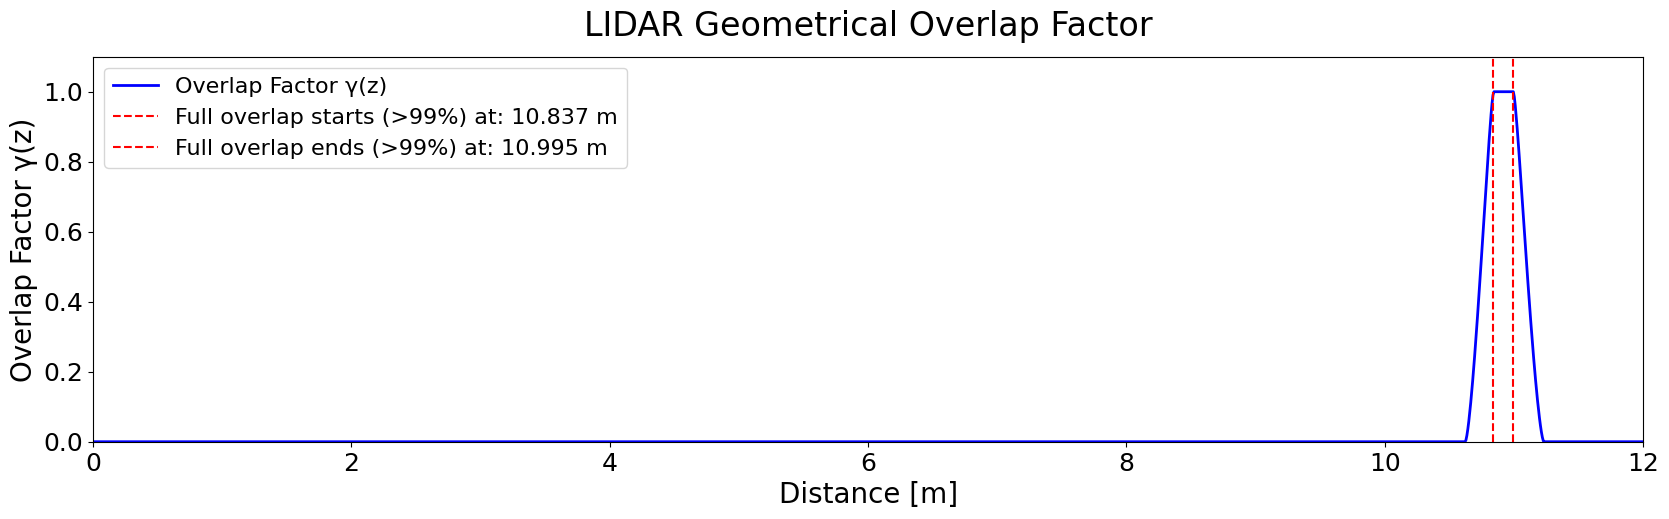

In [ ]:
# --------------------------
# Find full-overlap range
# --------------------------
try:
    # First non-zero overlap
    first_nonzero_idx = np.where(overlap_arr > 0)[0][0]
    first_nonzero_range = distance_z[first_nonzero_idx]

    # Last non-zero overlap
    last_nonzero_idx = np.where(overlap_arr > 0)[0][-1]
    last_nonzero_range = distance_z[last_nonzero_idx]

    # First point where overlap exceeds 0.99
    first_idx = np.where(overlap_arr > 0.99)[0][0]
    first_range = distance_z[first_idx]

    # Last point where overlap stays above 0.99
    last_idx = np.where(overlap_arr > 0.99)[0][-1]
    last_range = distance_z[last_idx]

    # Labels
    overlap_text_1a = f"Full overlap starts (>99%) at: {first_range:.3f} m"
    overlap_text_1b = f"Full overlap ends (>99%) at: {last_range:.3f} m"

except IndexError:
    first_nonzero_range = None
    last_nonzero_range = None
    first_range = None
    last_range = None
    overlap_text_0a = overlap_text_1a = overlap_text_1b = overlap_text_0b = "Overlap not reached."


# --------------------------
# Plot overlap factor
# --------------------------
print(f"Overlap starts (>0) at: {first_nonzero_range:.3f} m")
print(f"Overlap ends (=0) at: {last_nonzero_range:.3f} m")

plt.figure(figsize=(20, 5))
plt.title("LIDAR Geometrical Overlap Factor", fontsize=24, pad=15)

# Main curve
plt.plot(distance_z, overlap_arr, color='blue',linewidth=2, label="Overlap Factor γ(z)")

# Add vertical dashed lines for start and end of full overlap
if first_range is not None:
    plt.axvline(x=first_range, color='red', linestyle='--', linewidth=1.5, label=f"Full overlap starts (>99%) at: {first_range:.3f} m")

if last_range is not None and last_range > first_range:
    plt.axvline(x=last_range, color='red', linestyle='--', linewidth=1.5, label=f"Full overlap ends (>99%) at: {last_range:.3f} m")

# Axis labels and limits
plt.xlabel("Distance [m]", fontsize=20)
plt.ylabel("Overlap Factor γ(z)", fontsize=20)
plt.xlim(0, distance_range_m)  # set x-axis limits
plt.ylim(0, 1.1)               # set y-axis limits
plt.tick_params(axis='both', labelsize=18)
plt.legend(loc='upper left', fontsize=16)
plt.show()

# Section 8 The TCSPC model
---
The stochastic photon detection process is implemented using a Monte-Carlo TCSPC algorithm that models individual photon arrival events under realistic signal and noise conditions. This procedure operates through two nested loops: an outer loop over laser pulses and an inner loop over discrete distance steps. The outer loop iterates over all laser pulses triggered within the integration period ($t_i$), where the total number of pulses is $P_{\text{total}} = t_i \times f_r$, with $f_r$ denoting the laser repetition rate. Within each pulse, the inner loop divides the total propagation range $Z_{\text{total}}$ into discrete distance steps determined primarily by the time resolution ($\delta t$) of the photon-counting electronics, which mainly depends on the time tagger. The distance increment is defined as $\delta z = \delta t \times c / 2$, where $c$ is the speed of light, and the total number of distance steps is $N_z = \frac{2Z_{\text{total}}}{c\,\delta t}$.

At each distance step, the combined photon detection probability ($p_{\text{total}}$) is computed from all contributing sources, including hydrogen Raman signal, Rayleigh leakage, water-vapor Raman crosstalk, detector dark counts, and solar background photons. Photon arrivals are modelled as a Poisson process, and a Bernoulli is applied to determine whether a photon detection occurs at that step. Specifically, a uniformly distributed random number $U \in (0,1)$ is generated, and a detection event is recorded if $U < p_{\text{total}}$.

When a photon is detected, a Gaussian random time shift is applied to account for timing jitter introduced by the finite laser pulse width ($P_w$), thereby simulating the temporal spread of photon arrivals. The detector dead time ($t_D$) is then enforced by skipping subsequent steps within the inactive range $z_{\text{dead}} = c \times t_D$, ensuring that no additional detections are registered during this period. Detected photons are accumulated into discrete time bins to form the photon-count histogram. After completing all pulse iterations, the simulation outputs an accumulated TCSPC histogram, representing the statistical distribution of photon arrival times.

By repeating this Monte-Carlo process over many pulses, the algorithm accurately reproduces the stochastic behaviour of photon detection, including Poisson-distributed photon arrivals, temporal jitter, and detector dead-time effects, thereby providing a realistic numerical model of single-photon counting in Raman LIDAR systems.

## Bernoulli Test

The Bernoulli test approach are equivalent in effect in the discrete-time context, as both yield the same stochastic realization of photon detection based on the Poisson arrival model.

**1. Discretised Form in TCSPC Simulation:**

In the TCSPC Raman lidar simulation, each time bin corresponds to a small time interval $\Delta t$.

Within each interval, there is a probability $p_i$ that a photon is detected — derived from the Poisson arrival rate $\lambda(t)$:

$p_i = 1 - e^{-\lambda(t_i)\,\Delta t} \approx \lambda(t_i)\,\Delta t$

(for low count rates, $p_i \ll 1$).

Then, performing a **Bernoulli trial** for each bin:

*   **Outcome 1**: A photon is detected (Count = 1)
*   **Outcome 0**: No photon is detected (Count = 0)

That is,

$P(Count=1)=p_i, P(Count=0)=1-p_i$

In code, this is implemented as:
```
if np.random.rand() < p_i:
    Count = 1
else:
    Count = 0
```

**2. How this Method generates the Bernoulli Event:**

`np.random.rand()` draws a random number $U$ uniformly distributed in $[0, 1)$.

The event $U < p_i$ happens with probability $p_i$.

So:

`Count = 1 if np.random.rand() < p else 0`

gives:

$P(Count=1)=P(U < p_i)=p_i$

⇒ This is a direct way to simulate a Bernoulli(p_i) random variable.

Physically, this represents the **Poissonian nature of photon arrivals** — random, independent events where each has a small detection probability $p_i$.

This formulation produce the physical behaviour:

*   Each bin can either register a photon (Count = 1) or none (Count = 0).
*   The probability of detection per bin is $p_i$, independent of other bins.
*   Over many pulses, the expected number of detections is $N_{pulses} \times, matching **Poisson statistics**.

Thus:

$E[Count]=p_i, Var[Count]=p_i(1-p_i)$

**3. Why Prefer np.random.rand() in Numba:**

*   TCSPC operates in the **photon-starved regime** — typically at most one photon per pulse.
*   Each interval’s detection probability $p_i$ is very small ($p_i \ll 1$), so multiple detections within one bin are negligible.
*   Therefore, Bernoulli test per bin accurately models Poisson photon arrivals filtered by the detection probability.
    
Over many pulses, the number of detected photons in bin $i$ follows $N_i \sim \mathrm{Poisson}(N_{\mathrm{pulses}}\,p_i)$, which is exactly what the TCSPC simulation histogram produces.

`np.random.rand()` is supported inside `@njit`, and runs in native machine code, making the simulation thousands of times faster.

It is therefore the preferred implementation for high-speed Monte Carlo TCSPC simulations, while remaining mathematically and physically identical to alternatives such as:

`Count = random.choices([1, 0], weights=(p, 1-p))[0]`

### Gaussian Time Jitter (Uncertainty in Time Bin Allocation)

Due to the laser pulse width (temporal spread), there is uncertainty in the allocation of counts to time bins. This uncertainty is modeled by assuming a **Gaussian pulse shape** and using a **Monte Carlo method**, where time bins are randomly sampled from a Gaussian distribution. The **standard deviation ($\sigma$)** of this distribution is determined by $\sigma = \frac{P_w(\text{FWHM})}{2\sqrt{2\ln 2}} \approx \frac{P_w(\text{FWHM})}{2.355}$, where $P_w(\text{FWHM}$ is **laser pulse width (FWHM)** for Lidar Equation. The resulting spread (i.e., standard deviation $\sigma$) in the uncertainty of time bin allocation is given by $Δn=\sigma/t_b$, where $t_b$ is the width of a single time bin.

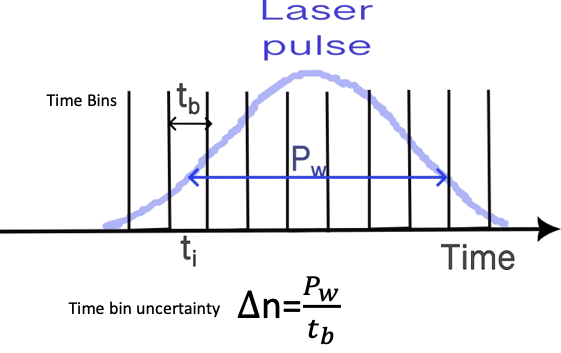

### Dead Time

For single-photon detectors, after a photon is detected, there is a period known as the **dead time**, during which the detector is unable to record subsequent photon arrivals.

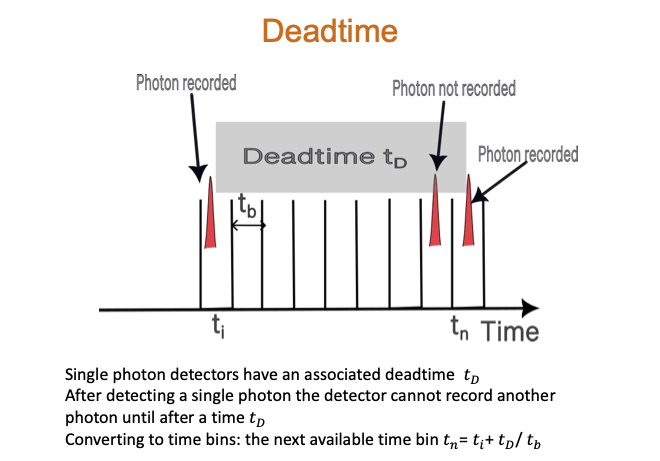

**In Monte-Carlo TCSPC Model**

`prob_total_arr` is a 1D array over the lidar range bins. Each element is the probability of detecting $\geq 1$ photon in that bin for a single laser pulse, already including:
*   Raman signal probability
*   Rayleigh crosstalk (not included in this case)
*   $H_2O$ Raman leakage
*   sky photons (not included in this case)
*   dark counts

So for bin $i$: $p_i = \mathrm{Prob}(\geq 1~\text{detection in bin } i \text{ during one pulse})$

Expected detections per pulse: each bin acts like an independent Bernoulli trial with small probability $p_i$.
*   For small $p_i$ ($\ll 1$), the expected number of detections per bin is approximately $p_i$
*   The total expected detections in a full lidar trace (all bins) per pulse is: $\mu = \sum_i p_i$

So, `prob_total_arr.sum()` is the mean number of detected photons per pulse.

*   If $\mu \ll 1$, the system is operating in the **photon-counting regime** — typically ideal for TCSPC.
*   If $\mu \approx 1$, most pulses produce exactly one photon (detector saturates).
*   If $\mu > 1$, enter the **pile-up regime** — multiple photons per pulse, so **dead time** and **timing distortions** dominate.

## Modelled $H_2$ - $no$ $H_2$ Raman
C(H2) = 1850 ppm @ 11.351 m, indoor: prob_{sky} = 0

integration_time = 600s: 355nm, 0.82ns, 3.527uJ, 10kHz (all CryLas)

Lidar efficiency: 0.0180

Number of pulses: 6000000.0

In [ ]:
## ==========================================================
#  TCSPC (Time-Correlated Single-Photon Counting) Simulation for Raman Lidar Hydrogen Detection
# ==========================================================
# This section:
#   - Excludes very close distance bins (< Start_m)
#   - Precomputes detection probabilities for each range bin
#   - Runs a fast Numba Monte Carlo simulation of photon arrivals
#   - Plots the simulated histogram vs. gas concentration
# ==========================================================

# --------------------------
# Exclude bins < Start_m
# --------------------------
# Find the first bin where distance_z >= Start_m
i_start = np.searchsorted(distance_z, Start_m)

# Slice all relevant arrays from that index onward
distance_z = distance_z[i_start:]              # keep valid ranges only
overlap_arr = overlap_arr[i_start:]            # corresponding overlap factors
Gas_conc_percent_H2 = Gas_conc_percent_H2[i_start:]  # gas concentration profile aligned to z


# --------------------------
# Precompute probabilities
# --------------------------
# For each distance bin, precompute the detection probability for H2 Raman, Rayleigh leakage, and H2O Raman leakage.
# This avoids recalculating physics inside the Monte Carlo loop.

# === H₂ Raman signal ===
# H2 Raman: scale the mean (lambda) by T_pump * T_Raman * overlap, then convert to probability: P = 1 - exp(-λ)
prob_H2_Raman_arr = 1 - np.exp(-np.array([
    Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                H2_Ramanxsection, H2_RamanStokes, z_here,
                Lidarconstant_H2, Gas_conc_percent_H2[i], Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)          # transmission along pump path
    * uv_transmission(H2_Raman_wavelength, z_here)  # transmission along return path
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Rayleigh leakage (crosstalk from pump channel) ===
# Correct treatment: compute mean via Rayleigh_Lidar, scale by T_pump^2 and overlap, then 1 - exp(-λ)
prob_air_Rayleigh_arr_H2 = np.array([
    Air_Rayleigh_prob(Pump_Lambda, Crosstalk_Rayleigh, Pulse_FWHM_s,
                      Pump_photons, z_here,
                      Lidarconstant_H2, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)**2       # transmission forward + backward
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
])

# === H₂O Raman leakage ===
prob_H2O_Raman_arr_H2 = 1 - np.exp(-np.array([
    Crosstalk_H2O * Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                                H2O_Ramanxsection, H2O_RamanStokes, z_here,
                                Lidarconstant_H2, H2Oconcentration, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)           # transmission pump path
    * uv_transmission(H2O_Raman_wavelength, z_here)  # transmission Raman return path
    * overlap_arr[i]                                 # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Combine all probability components ===
# We add constant background probabilities for dark counts and (optionally) sky photons. Then we sum all per-bin probabilities and clip to [0, 1].
# This forms the total photon-detection probability distribution used by the Monte Carlo.
prob_sky_H2 = 0                                   # scalar, indoor experiment
prob_dark_H2 = Darkcount(darkcountrate, delta_t)  # scalar, constant dark count probability per bin

# Combine and clip
prob_total_arr_H2 = np.clip(prob_sky_H2 + prob_dark_H2 + prob_H2_Raman_arr +
                         prob_air_Rayleigh_arr_H2 + prob_H2O_Raman_arr_H2, 0, 1)


# --------------------------
# Fast TCSPC Monte Carlo loop (Numba)
# --------------------------
# Outer loop over pulses, inner loop over timesteps.
# The loop uses random draws against precomputed probabilities to decide if a photon is detected in each bin.
# If a photon is detected, Gaussian time jitter is applied (to mimic pulse width) and detector deadtime is enforced (skip bins).
@njit
def run_tcspc(prob_total_arr_H2, number_of_pulses, deadtime_steps, pulse_in_timesteps):
    """
    Monte-Carlo simulation of TCSPC events in a Raman Lidar system for H2 detection.
    This function models stochastic photon detection across multiple laser pulses.
    Each distance STEP has an associated total detection probability that incorporates contributions from the Raman signal and various noise sources.
    The simulation accounts for both detector deadtime and Gaussian time jitter to emulate realistic photon arrival statistics.

    Inputs:
      prob_total_arr_H2  - [0–1], probability of detecting H2 ≥1 photon in each distance step
      number_of_pulses   - number of laser pulses (Monte-Carlo iterations)
      deadtime_steps     - detector deadtime (in distance steps); suppresses further detections for the specified duration after each photon event
      pulse_in_timesteps - standard deviation (width) of Gaussian timing jitter (in distance steps) to simulate timing spread of detection events

    Output:
      H2_signal_spread   - histogram of detected photon counts per distance step;
                           each element gives the accumulated number of detected photons over all simulated laser pulses
    """

    # Total number of range bins
    nsteps_H2 = len(prob_total_arr_H2)

    # Initialize histogram to store photon detections
    H2_signal_spread = np.zeros(nsteps_H2, dtype=np.int32)

    # Outer loop: iterate over all laser pulses
    for j in range(number_of_pulses):

        # Initialize the distance step index for this pulse
        i = 0
        # Inner loop: iterate through distance steps
        while i < nsteps_H2:

            # Random draw against detection probability in current bin (Bernoulli(p_total) Test)
            if np.random.rand() < prob_total_arr_H2[i]:  # draw U ∈ [0,1); detection occurs if U < p_total_arr[i]: photon detected? Yes / No

                # Photon detected ⇒ apply Gaussian time jitter (pulse spread)
                s = i + int(round(np.random.normal(0.0, pulse_in_timesteps)))
                # Add photon count if the jittered index is valid
                if 0 <= s < nsteps_H2:
                    H2_signal_spread[s] += 1  # register photon count

                # Apply detector deadtime: skip bins where the detector is inactive
                i += deadtime_steps

            else:
                # No photon detected ⇒ move to the next distance step
                i += 1

    return H2_signal_spread  # return accumulated histogram of detected photons across all pulses

# Run the accelerated Monte Carlo
H2_signal_spread = run_tcspc(prob_total_arr_H2, number_of_pulses, deadtime_steps, pulse_in_timesteps)  # accumulated photon counts per timestep


# --------------------------
# Summary & Printing
# --------------------------
print("\n--- Probability (sum) ---")
print(f"Total probability of a count: {prob_total_arr_H2.sum():.2e}\n"  # mu, expected detections per pulse
      f"dark: {prob_dark_H2:.2e}\n"
      f"H2 Raman: {prob_H2_Raman_arr.sum():.2e}\n"
      f"air Rayleigh: {prob_air_Rayleigh_arr_H2.sum():.2e}\n"
      f"H2O Raman: {prob_H2O_Raman_arr_H2.sum():.2e}")
print(f"\nBackground_H2: {Background_H2_ppm} ppm")

peak_H2_model = max(H2_signal_spread)
# Find index of the maximum photon count
idx_model_max_H2 = np.argmax(H2_signal_spread)
z_model_max_H2 = distance_z[idx_model_max_H2]
print(f"Modelled H2 Raman: max {peak_H2_model:.0f} @ {z_model_max_H2:.3f} m")


--- Probability (sum) ---
Total probability of a count: 1.59e-03
dark: 6.00e-07
H2 Raman: 6.32e-04
air Rayleigh: 1.61e-09
H2O Raman: 4.80e-08

Background_H2: 0.53 ppm
Modelled H2 Raman: max 228 @ 10.950 m


### TCSPC result vs gas cloud

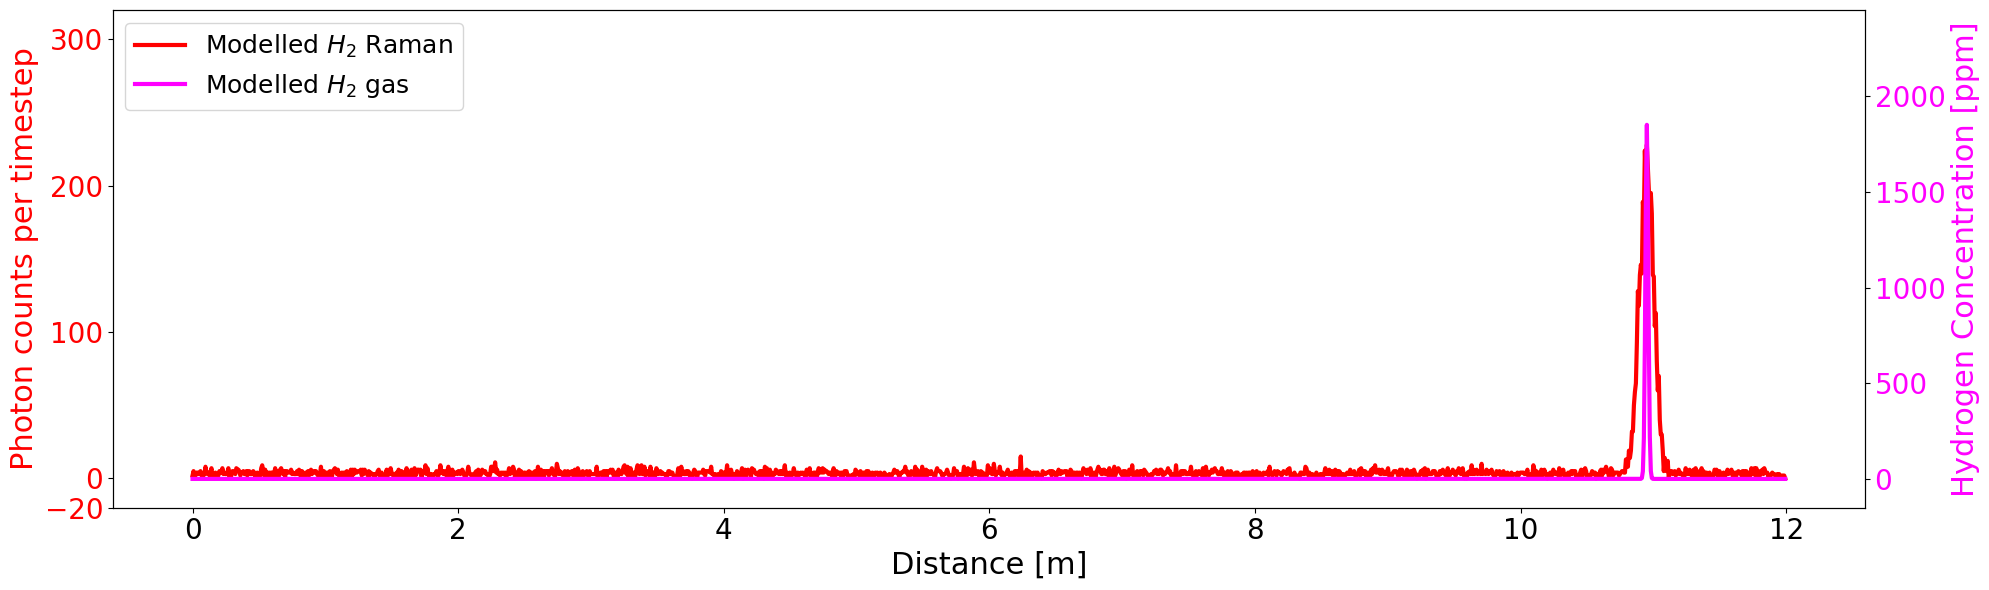

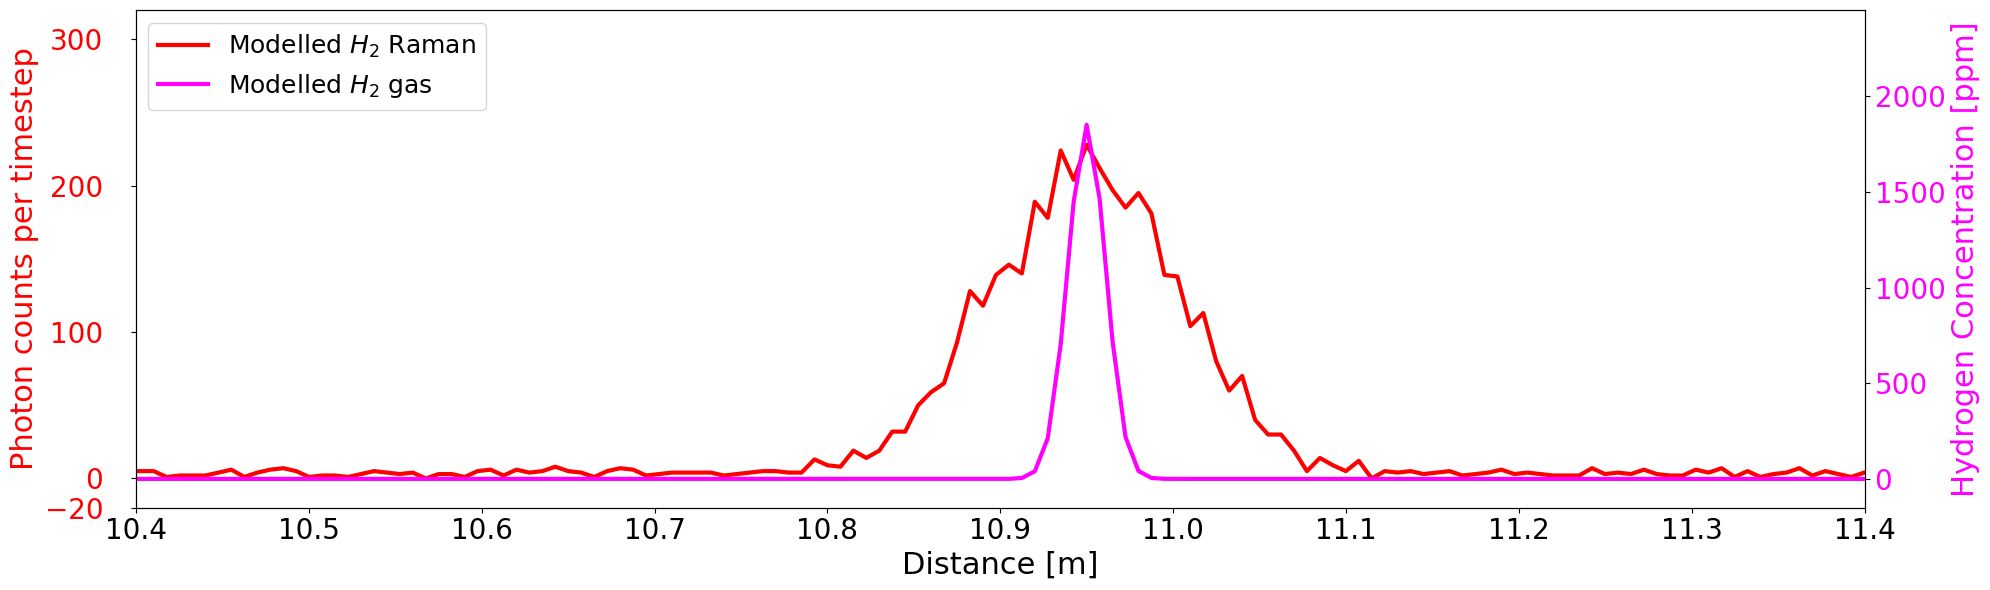

In [ ]:
# --------------------------
# Plot TCSPC result vs gas cloud
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $H_2$ Raman & Gas Concentration - Raman Pump @" + f"{Pump_Lambda:.1f} nm, "
#         + "Stokes @" + f"{H2_Raman_wavelength:.1f} nm", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per timestep', color='red', fontsize=22)
ax1.set_ylim(-20, 320)  # set y-axis limits
ax1.set_yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
ax1.plot(distance_z, H2_signal_spread, color='red', linewidth=3, label=f"Modelled $H_2$ Raman")
ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Hydrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.set_ylim(-150, 2450)  # set y-axis limits
ax2.plot(distance_z, Gas_conc_percent_H2*1e4, color='magenta', linewidth=3, label=f"Modelled $H_2$ gas")
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Plot TCSPC result vs gas cloud (Zoomed in to 10.4–11.4 m)
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $H_2$ Raman and Gas Concentration (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per timestep', color='red', fontsize=22)
ax1.set_xlim(10.4, 11.4)  # set x-axis limits
ax1.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax1.set_ylim(-20, 320)  # set y-axis limits
ax1.set_yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
ax1.plot(distance_z, H2_signal_spread, color='red', linewidth=3, label=f"Modelled $H_2$ Raman")
ax1.tick_params(axis='y', labelcolor='red', labelsize=20, pad=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Hydrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.set_xlim(10.4, 11.4)  # set x-axis limits
ax2.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax2.set_ylim(-150, 2450)  # set y-axis limits
ax2.plot(distance_z, Gas_conc_percent_H2*1e4, color='magenta', linewidth=3, label=f"Modelled $H_2$ gas")
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()

## Modelled $N_2$ Raman
indoor: prob_{sky} = 0

integration_time = 600s: 355nm, 0.82ns, 3.527uJ, 10kHz (all CryLas)

Lidar efficiency: 0.0044

Number of pulses: 6000000.0

C(N2) = 780000ppm

In [ ]:
## ==========================================================
#  TCSPC (Time-Correlated Single-Photon Counting) Simulation for Raman Lidar Hydrogen Detection
# ==========================================================
# This section:
#   - Excludes very close distance bins (< Start_m)
#   - Precomputes detection probabilities for each range bin
#   - Runs a fast Numba Monte Carlo simulation of photon arrivals
#   - Plots the simulated histogram vs. gas concentration
# ==========================================================

# --------------------------
# Exclude bins < Start_m
# --------------------------
# Find the first bin where distance_z >= Start_m
i_start = np.searchsorted(distance_z, Start_m)

# Slice all relevant arrays from that index onward
distance_z = distance_z[i_start:]              # keep valid ranges only
overlap_arr = overlap_arr[i_start:]            # corresponding overlap factors
Gas_conc_percent_N2 = Gas_conc_percent_N2[i_start:]  # gas concentration profile aligned to z


# --------------------------
# Precompute probabilities
# --------------------------
# For each distance bin, precompute the detection probability for H2 Raman, Rayleigh leakage, and H2O Raman leakage.
# This avoids recalculating physics inside the Monte Carlo loop.

# === N₂ Raman signal ===
# N2 Raman: scale the mean (lambda) by T_pump * T_Raman * overlap, then convert to probability: P = 1 - exp(-λ)
prob_N2_Raman_arr = 1 - np.exp(-np.array([
    Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                N2_Ramanxsection, N2_RamanStokes, z_here,
                Lidarconstant_N2, Gas_conc_percent_N2[i], Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)          # transmission along pump path
    * uv_transmission(N2_Raman_wavelength, z_here)  # transmission along return path
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Rayleigh leakage (crosstalk from pump channel) ===
# Correct treatment: compute mean via Rayleigh_Lidar, scale by T_pump^2 and overlap, then 1 - exp(-λ)
prob_air_Rayleigh_arr_N2 = np.array([
    Air_Rayleigh_prob(Pump_Lambda, Crosstalk_Rayleigh, Pulse_FWHM_s,
                      Pump_photons, z_here,
                      Lidarconstant_N2, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)**2       # transmission forward + backward
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
])

# === H₂O Raman leakage ===
prob_H2O_Raman_arr_N2 = 1 - np.exp(-np.array([
    Crosstalk_H2O * Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                                H2O_Ramanxsection, H2O_RamanStokes, z_here,
                                Lidarconstant_N2, H2Oconcentration, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)           # transmission pump path
    * uv_transmission(H2O_Raman_wavelength, z_here)  # transmission Raman return path
    * overlap_arr[i]                                 # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Combine all probability components ===
# We add constant background probabilities for dark counts and (optionally) sky photons. Then we sum all per-bin probabilities and clip to [0, 1].
# This forms the total photon-detection probability distribution used by the Monte Carlo.
prob_sky_N2 = 0                                   # scalar, indoor experiment
prob_dark_N2 = Darkcount(darkcountrate, delta_t)  # scalar, constant dark count probability per bin

# Combine and clip
prob_total_arr_N2 = np.clip(prob_sky_N2 + prob_dark_N2 + prob_N2_Raman_arr +
                         prob_air_Rayleigh_arr_N2 + prob_H2O_Raman_arr_N2, 0, 1)


# --------------------------
# Fast TCSPC Monte Carlo loop (Numba)
# --------------------------
# Outer loop over pulses, inner loop over timesteps.
# The loop uses random draws against precomputed probabilities to decide if a photon is detected in each bin.
# If a photon is detected, Gaussian time jitter is applied (to mimic pulse width) and detector deadtime is enforced (skip bins).
@njit
def run_tcspc(prob_total_arr_N2, number_of_pulses, deadtime_steps, pulse_in_timesteps):
    """
    Monte-Carlo simulation of TCSPC events in a Raman Lidar system for N2 detection.
    This function models stochastic photon detection across multiple laser pulses.
    Each distance STEP has an associated total detection probability that incorporates contributions from the Raman signal and various noise sources.
    The simulation accounts for both detector deadtime and Gaussian time jitter to emulate realistic photon arrival statistics.

    Inputs:
      prob_total_arr_N2  - [0–1], probability of detecting N2 ≥1 photon in each distance step
      number_of_pulses   - number of laser pulses (Monte-Carlo iterations)
      deadtime_steps     - detector deadtime (in distance steps); suppresses further detections for the specified duration after each photon event
      pulse_in_timesteps - standard deviation (width) of Gaussian timing jitter (in distance steps) to simulate timing spread of detection events

    Output:
      N2_signal_spread   - histogram of detected photon counts per distance step;
                           each element gives the accumulated number of detected photons over all simulated laser pulses
    """

    # Total number of range bins
    nsteps_N2 = len(prob_total_arr_N2)

    # Initialize histogram to store photon detections
    N2_signal_spread = np.zeros(nsteps_N2, dtype=np.int32)

    # Outer loop: iterate over all laser pulses
    for j in range(number_of_pulses):

        # Initialize the distance step index for this pulse
        i = 0
        # Inner loop: iterate through distance steps
        while i < nsteps_N2:

            # Random draw against detection probability in current bin (Bernoulli(p_total) Test)
            if np.random.rand() < prob_total_arr_N2[i]:  # draw U ∈ [0,1); detection occurs if U < p_total_arr[i]: photon detected? Yes / No

                # Photon detected ⇒ apply Gaussian time jitter (pulse spread, σ in bins)
                s = i + int(round(np.random.normal(0.0, pulse_in_timesteps)))
                # Add photon count if the jittered index is valid
                if 0 <= s < nsteps_N2:
                    N2_signal_spread[s] += 1  # register photon count

                # Apply detector deadtime: skip bins where the detector is inactive
                i += deadtime_steps

            else:
                # No photon detected ⇒ move to the next distance step
                i += 1

    return N2_signal_spread  # return accumulated histogram of detected photons across all pulses

# Run the accelerated Monte Carlo
N2_signal_spread = run_tcspc(prob_total_arr_N2, number_of_pulses, deadtime_steps, pulse_in_timesteps)  # accumulated photon counts per timestep


# --------------------------
# Summary & Printing
# --------------------------
print("\n--- Probability (sum) ---")
print(f"Total probability of a count: {prob_total_arr_N2.sum():.2e}\n"  # mu, expected detections per pulse
      f"sky: {prob_sky_N2:.0f}\n"
      f"dark: {prob_dark_N2:.2e}\n"
      f"N2 Raman: {prob_N2_Raman_arr.sum():.2e}\n"
      f"air Rayleigh: {prob_air_Rayleigh_arr_N2.sum():.2e}\n"
      f"H2O Raman: {prob_H2O_Raman_arr_N2.sum():.2e}")

peak_N2_model = max(N2_signal_spread)
# Find index of the maximum photon count
idx_model_max_N2 = np.argmax(N2_signal_spread)
z_model_max_N2 = distance_z[idx_model_max_N2]
print(f"Modelled N2 Raman: max {peak_N2_model:.0f} @ {z_model_max_N2:.3f} m")


--- Probability (sum) ---
Total probability of a count: 2.61e-01
sky: 0
dark: 6.00e-07
N2 Raman: 2.60e-01
air Rayleigh: 3.93e-10
H2O Raman: 1.17e-08
Modelled N2 Raman: max 28574 @ 10.882 m


### TCSPC result vs gas cloud

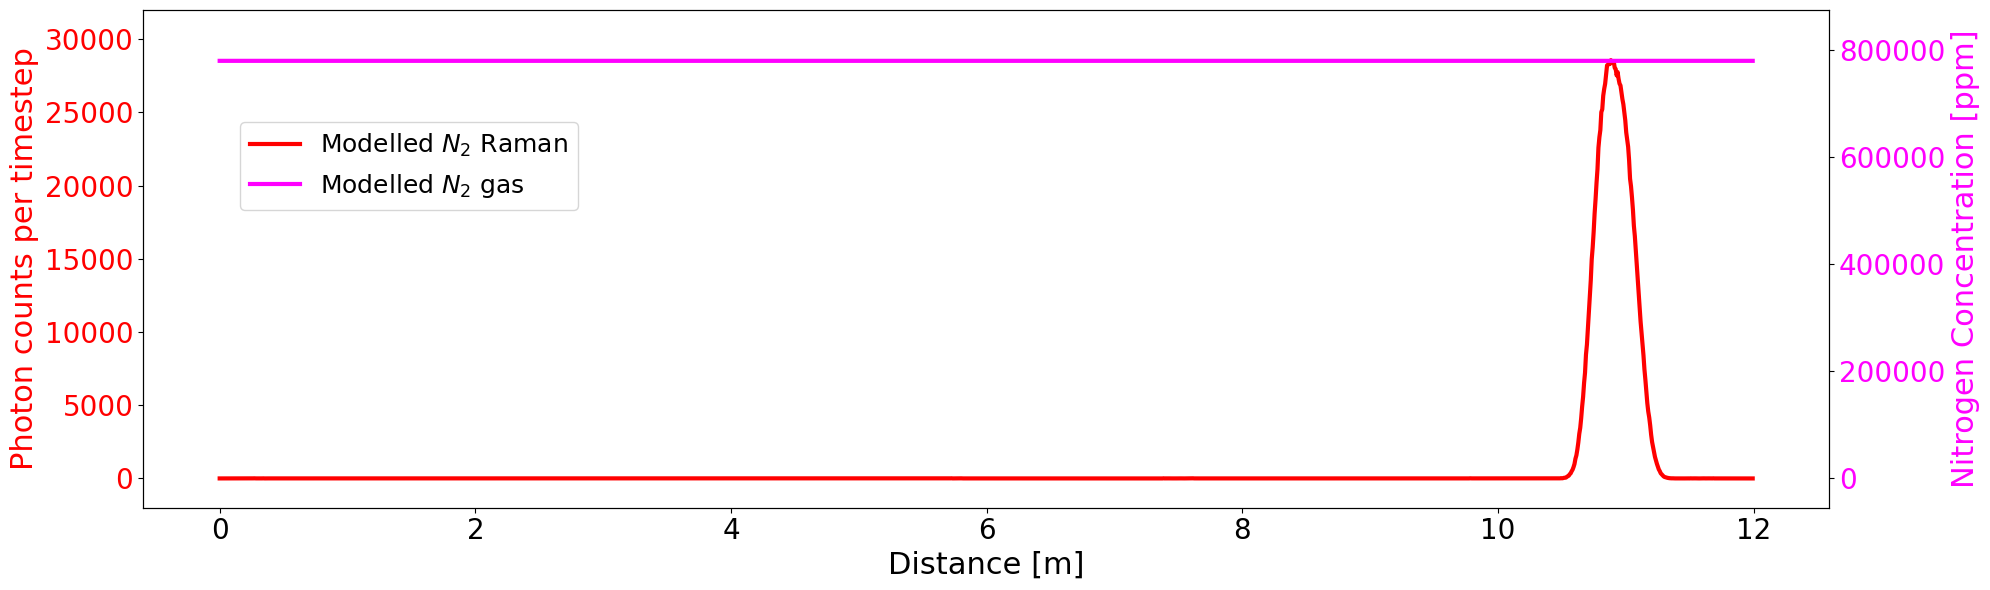

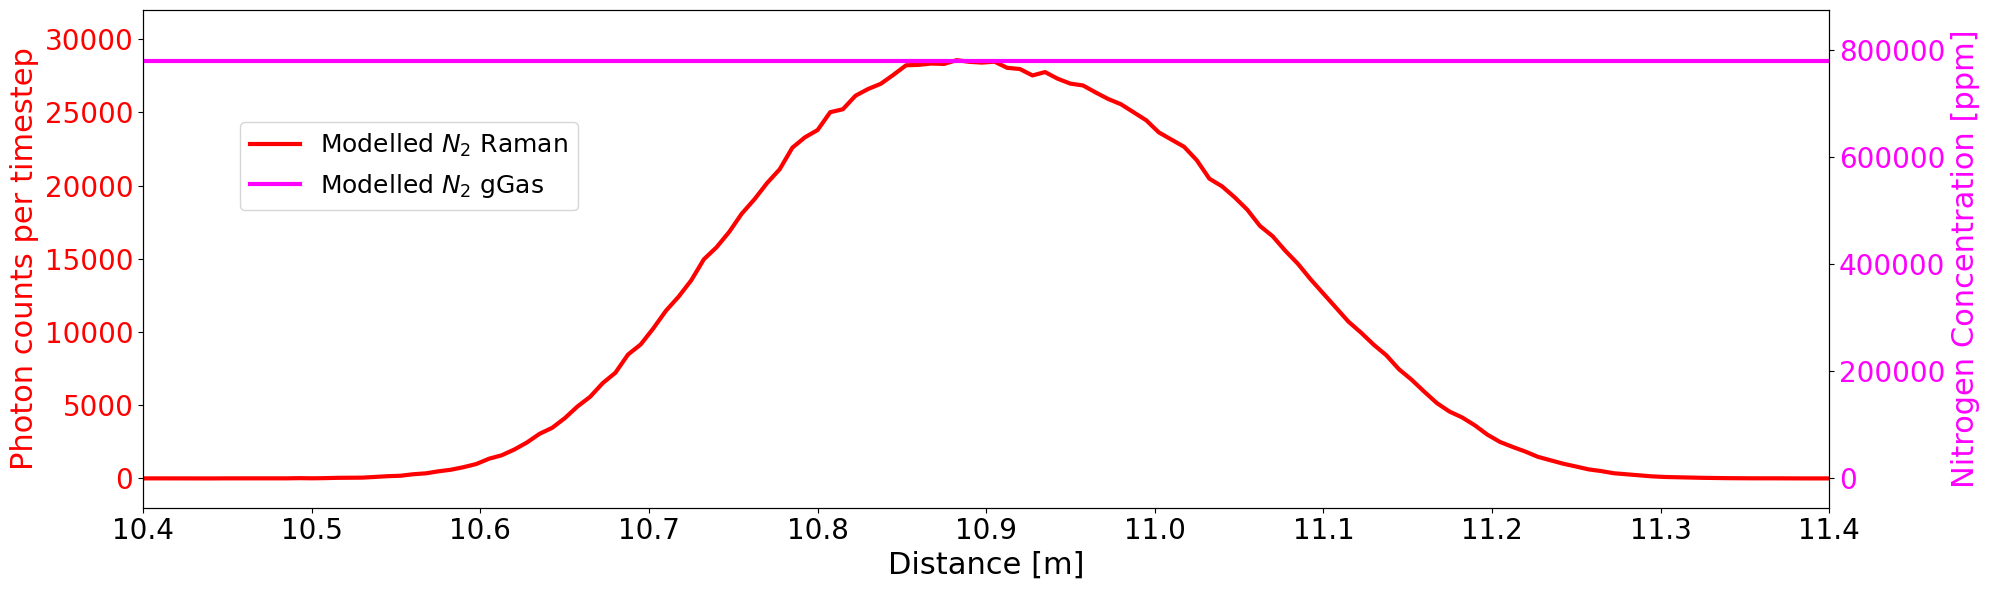

In [ ]:
# --------------------------
# Plot TCSPC result vs gas cloud
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $N_2$ Raman & Gas Concentration - Raman Pump @" + f"{Pump_Lambda:.1f} nm, "
#         + "Stokes @" + f"{N2_Raman_wavelength:.1f} nm", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per timestep', color='red', fontsize=22)
ax1.plot(distance_z, N2_signal_spread, color='red', linewidth=3, label=f"Modelled $N_2$ Raman")
ax1.set_ylim(-2000, 32000)  # set y-axis limits
ax1.set_yticks(np.arange(0, 32000, 5000))  # set y-tick marks
ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Nitrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.plot(distance_z, Gas_conc_percent_N2*1e4, color='magenta', linewidth=3, label=f"Modelled $N_2$ gas")
ax2.set_ylim(-55000, 875000)  # set y-limits
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.05, 0.8), fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Plot TCSPC result vs gas cloud (Zoomed in to 10.4–11.4 m)
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $N_2$ Raman and Gas Concentration (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per timestep', color='red', fontsize=22)
ax1.set_xlim(10.4, 11.4)  # set x-axis limits
ax1.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax1.set_ylim(-2000, 32000)  # set y-axis limits
ax1.set_yticks(np.arange(0, 32000, 5000))  # set y-tick marks
ax1.plot(distance_z, N2_signal_spread, color='red', linewidth=3, label=f"Modelled $N_2$ Raman")
ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Nitrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.set_xlim(10.4, 11.4)  # set x-axis limits
ax2.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax2.set_ylim(-55000, 875000)  # set y-limits
ax2.plot(distance_z, Gas_conc_percent_N2*1e4, color='magenta', linewidth=3, label=f"Modelled $N_2$ gGas")
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.05, 0.8), fontsize=18)
plt.tight_layout()
plt.show()

# Section 9-1 Comparison of Measured and Modelled $H_2$ Raman

## Measured $H_2$ Data
---
C(H2) = 1700-2000ppm @ 10.950m - GasDog, 10mins
> 260108-C(H2) Raman,10m,10mins (Andrew).csv

### Plot the $H_2$ & $no$ $H_2$ data

In [ ]:
# --------------------------
# Measured H2 data (Raman Lidar)
# --------------------------
# Load measured data from Google Drive (in Google Colab) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# URL to measured data file on Dropbox
URL_Measured_Raman = 'https://www.dropbox.com/scl/fi/6z2sjrsr7e43yv1froxkt/260108-C-H2-Raman-10m-10mins-Andrew.csv?rlkey=x336mebfnbhhruvuh4rukqyxq&st=29bw6f01&raw=1'  # Remember to replace dl = 0 with raw = 1
# Read CSV, skip first row (header info)
H2_Raman = pd.read_csv(URL_Measured_Raman)

# # Mount Google Drive
# drive.mount('/content/drive')
# # Path to CSV (adjust your filename accordingly)
# csv_path = '/content/drive/My Drive/Colab Notebooks/2 H2 Raman Lidar Results/250404-Data,Real H2%/260108-C(H2) Raman,10m,10mins (Andrew).csv'
# # Load the CSV file
# H2_Raman = pd.read_csv(csv_path)


# --------------------------
# Printing & Plotting
# --------------------------
# Display the first few rows
print(H2_Raman.head())

# Create the plot
import plotly.graph_objects as go

f1 = go.Figure(
    data = [
        go.Scatter(x=H2_Raman['Distance'], y=H2_Raman['H2'], name='H₂ at 11.351 m', mode='lines', line=dict(color='green')),
        go.Scatter(x=H2_Raman['Distance'], y=H2_Raman['no_H2'], name='no H₂ at 11.351 m', mode='lines', line=dict(color='red'))
    ],
    layout = {'xaxis': {'title': 'Distance (m)'}, 'yaxis': {'title': 'Photon counts per time bin'}, 'title': 'Comparison H2 and no H2 at 11.351 m'}
)
# Format y-axis to show 3 decimal places
f1.update_xaxes(tickformat=".3f")
f1.show()

   Distance  no_H2    H2   N2
0  0.000000    7.0   7.0  1.0
1  0.007495    4.0  12.0  0.0
2  0.014990   17.0   5.0  1.0
3  0.022484    8.0  12.0  2.0
4  0.029979   14.0   5.0  1.0


#### $H_2$ data - Electrolysis Cell On

Measured H2 Electrolysis Cell On: max 277 @ 10.950 m (within 8–12 m)


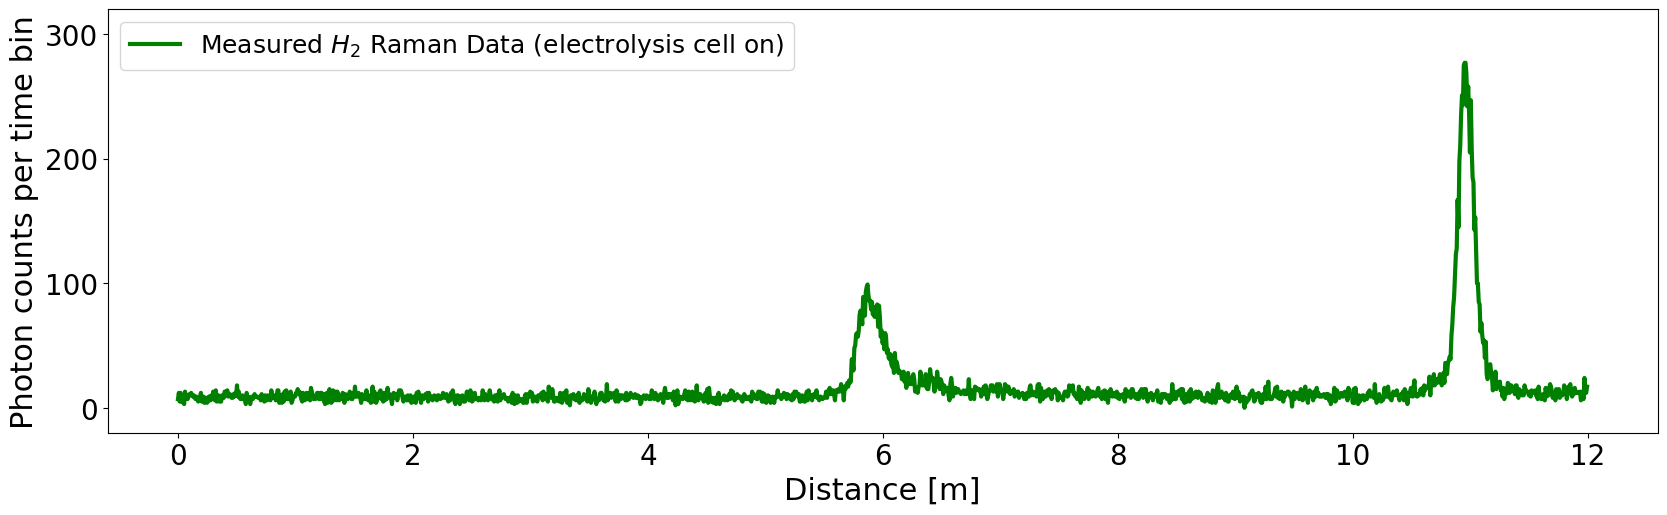

In [ ]:
# --------------------------
# Compute H2 peak in 8–12 m range
# --------------------------
# Filter data between 8 and 12 m
subset = H2_Raman[(H2_Raman['Distance'] >= 8) & (H2_Raman['Distance'] <= 12)]

# Calculate max value in that range
peak_H2 = subset['H2'].max()

# Find the distance where that maximum occurs
z_peak_H2 = subset.loc[subset['H2'].idxmax(), 'Distance']

print(f"Measured H2 Electrolysis Cell On: max {peak_H2:.0f} @ {z_peak_H2:.3f} m (within 8–12 m)")


# --------------------------
# Matplotlib static plot
# --------------------------
plt.figure(figsize = (20, 5.5))
#plt.title("Measured $H_2$ Raman Channel Data with Electrolysis Cell On", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2'],
    color='green',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on)")
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.ylim(-20, 320)                  # set y-axis limits
plt.yticks(np.arange(0, 320, 100))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

#### $no$ $H_2$ data - Electrolysis Cell Off

Measured H2 Electrolysis Cell Off: max 73 @ 10.957 m (within 8–12 m)


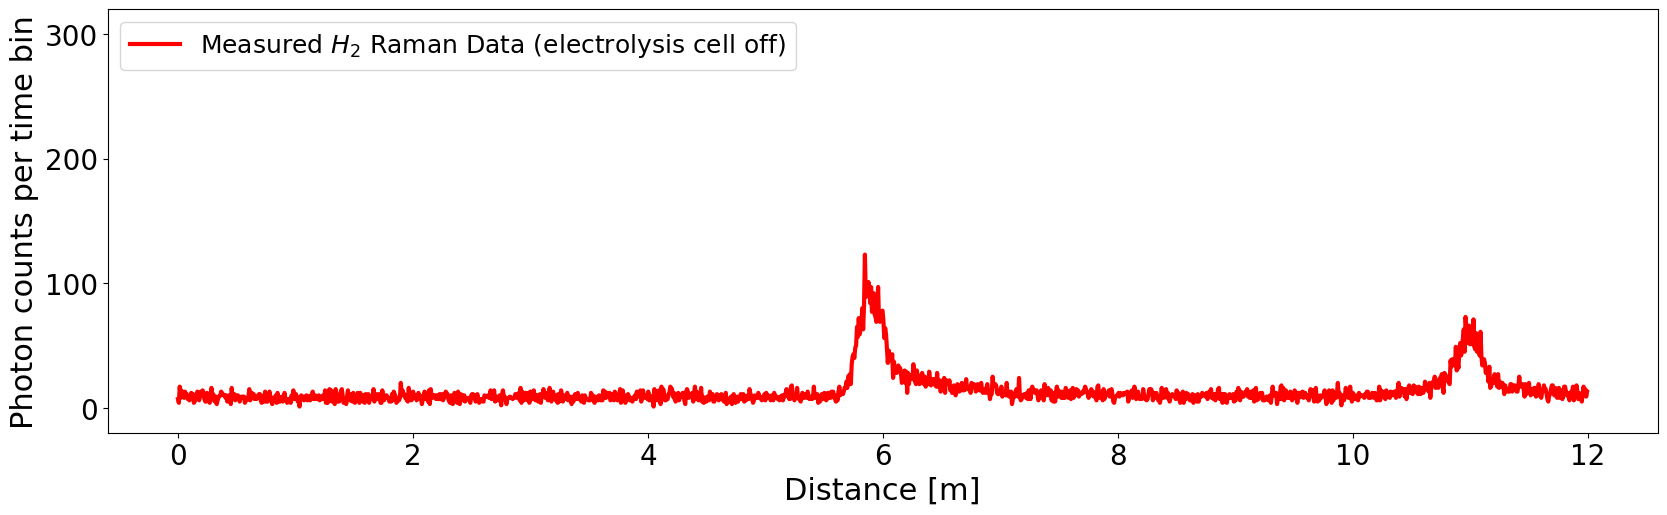

In [ ]:
# --------------------------
# Compute no H2 peak in 8–12 m range
# --------------------------
# Filter data between 8 and 12 m
subset = H2_Raman[(H2_Raman['Distance'] >= 8) & (H2_Raman['Distance'] <= 12)]

# Calculate max value in that range
peak_no_H2 = subset['no_H2'].max()

# Find the distance where that maximum occurs
z_peak_no_H2 = subset.loc[subset['no_H2'].idxmax(), 'Distance']

print(f"Measured H2 Electrolysis Cell Off: max {peak_no_H2:.0f} @ {z_peak_no_H2:.3f} m (within 8–12 m)")


# --------------------------
# Matplotlib static plot
# --------------------------
plt.figure(figsize = (20, 5.5))
#plt.title("Measured $H_2$ Raman Channel Data with Electrolysis Cell Off", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['no_H2'],
    color='red',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell off)"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.ylim(-20, 320)                  # set y-axis limits
plt.yticks(np.arange(0, 320, 100))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

### Plot the $H_2$ - $no$ $H_2$ data

In [ ]:
# --------------------------
# Compute pure H2 (H2 - no H2)
# --------------------------
H2_Raman['H2_minus_noH2'] = H2_Raman['H2'] - H2_Raman['no_H2']

# --------------------------
# Plot pure H2 (H2 - no H2)
# --------------------------
import plotly.graph_objects as go

f2 = go.Figure(
    data = [
        go.Scatter(x=H2_Raman['Distance'], y=H2_Raman['H2'], name='H₂ at 11.351 m', mode='lines', line=dict(color='green')),
        go.Scatter(x=H2_Raman['Distance'], y=H2_Raman['no_H2'], name='no H₂ at 11.351 m', mode='lines', line=dict(color='red')),
        go.Scatter(x=H2_Raman['Distance'], y=H2_Raman['H2_minus_noH2'], name='H₂ - no H₂ at 11.351 m', mode='lines', line=dict(color='blue')),
    ],
    layout = {'xaxis': {'title': 'Distance (m)'}, 'yaxis': {'title': 'Photon counts per time bin'}, 'title': 'Pure H2 (H2 - no H2) at 11.351 m'}
)
# Format y-axis to show 3 decimal places
f2.update_xaxes(tickformat=".3f")
f2.show()

#### $H_2$ - $no$ $H_2$ data

Measured H2 Electrolysis Cell On minus Off: max 232 @ 10.950 m


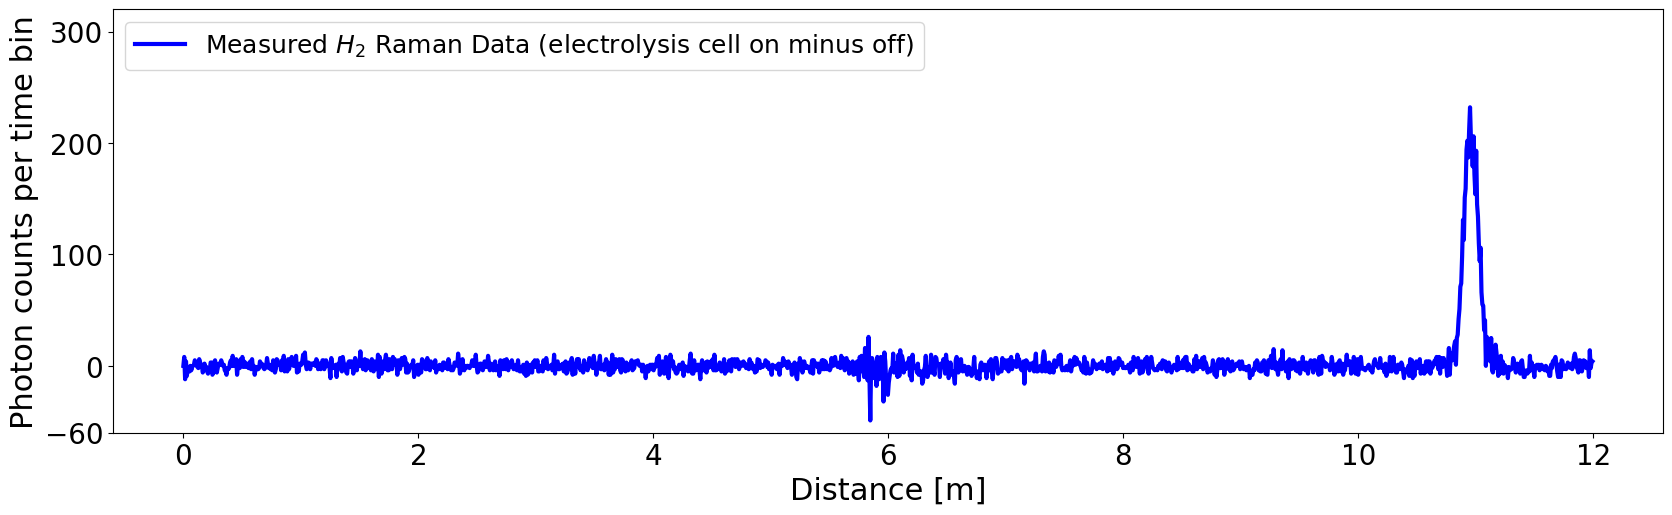

In [ ]:
# --------------------------
# Compute pure H2 (H2 - no H2)
# --------------------------
H2_Raman['H2_minus_noH2'] = H2_Raman['H2'] - H2_Raman['no_H2']
#H2_Raman['H2_minus_noH2'] = H2_Raman['H2_minus_noH2'].clip(lower=0)  # set negatives to zero


# --------------------------
# Compute pure H2 (H2 - no H2) peak
# --------------------------
# Calculate max value in that range
peak_pure_H2 = H2_Raman['H2_minus_noH2'].max()

# Find the distance where that maximum occurs
z_peak_pure_H2 = H2_Raman.loc[H2_Raman['H2_minus_noH2'].idxmax(), 'Distance']

print(f"Measured H2 Electrolysis Cell On minus Off: max {peak_pure_H2:.0f} @ {z_peak_pure_H2:.3f} m")


# --------------------------
# Matplotlib static plot
# --------------------------
plt.figure(figsize = (20, 5.5))
#plt.title("Measured $H_2$ Raman Channel Data with Electrolysis Cell On minus Off", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2_minus_noH2'],
    color='blue',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.ylim(-60, 320)  # set y-axis limits
plt.yticks([-60] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

Measured H2 Electrolysis Cell On minus Off: max 232 @ 10.950 m


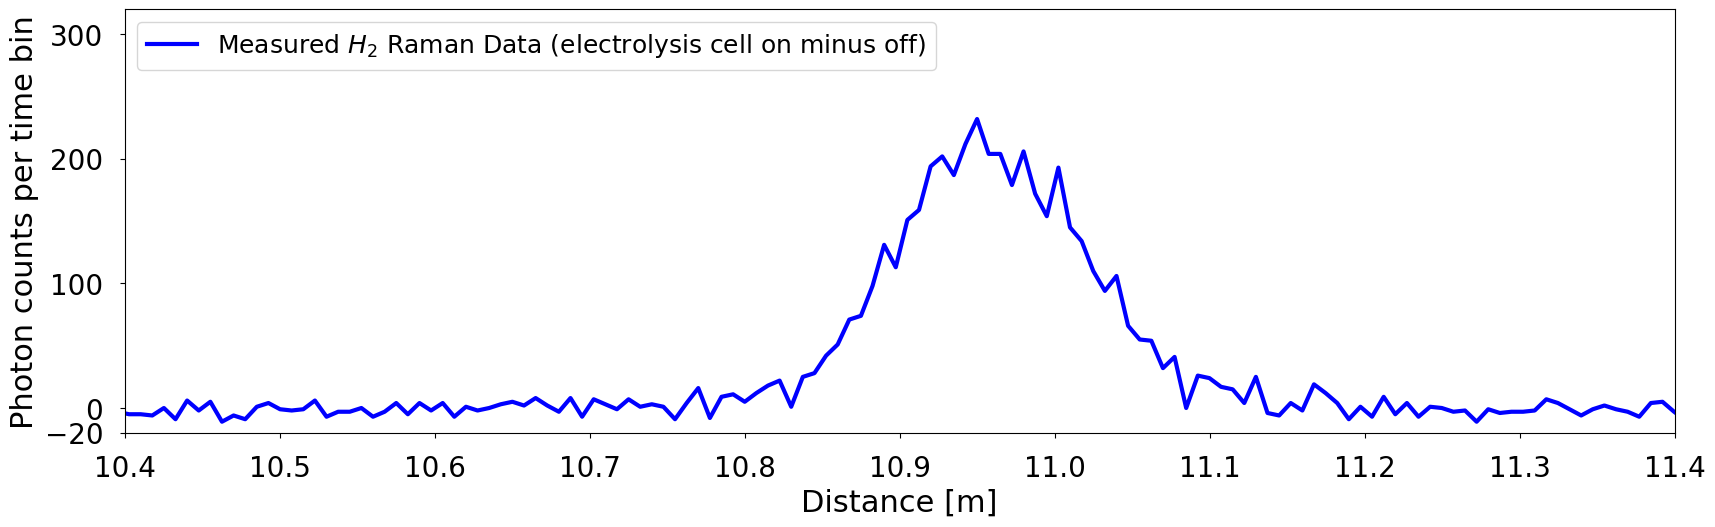

In [ ]:
print(f"Measured H2 Electrolysis Cell On minus Off: max {peak_pure_H2:.0f} @ {z_peak_pure_H2:.3f} m")


# --------------------------
# Matplotlib static plot
# --------------------------
plt.figure(figsize = (20, 5.5))
#plt.title("Measured $H_2$ Raman Channel Data with Electrolysis Cell On minus Off (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2_minus_noH2'],
    color='blue',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20, pad=12)
plt.legend(loc='upper left', fontsize=18)
plt.show()

### Measured $H_2$ Data & Modelled $H_2$ Gas

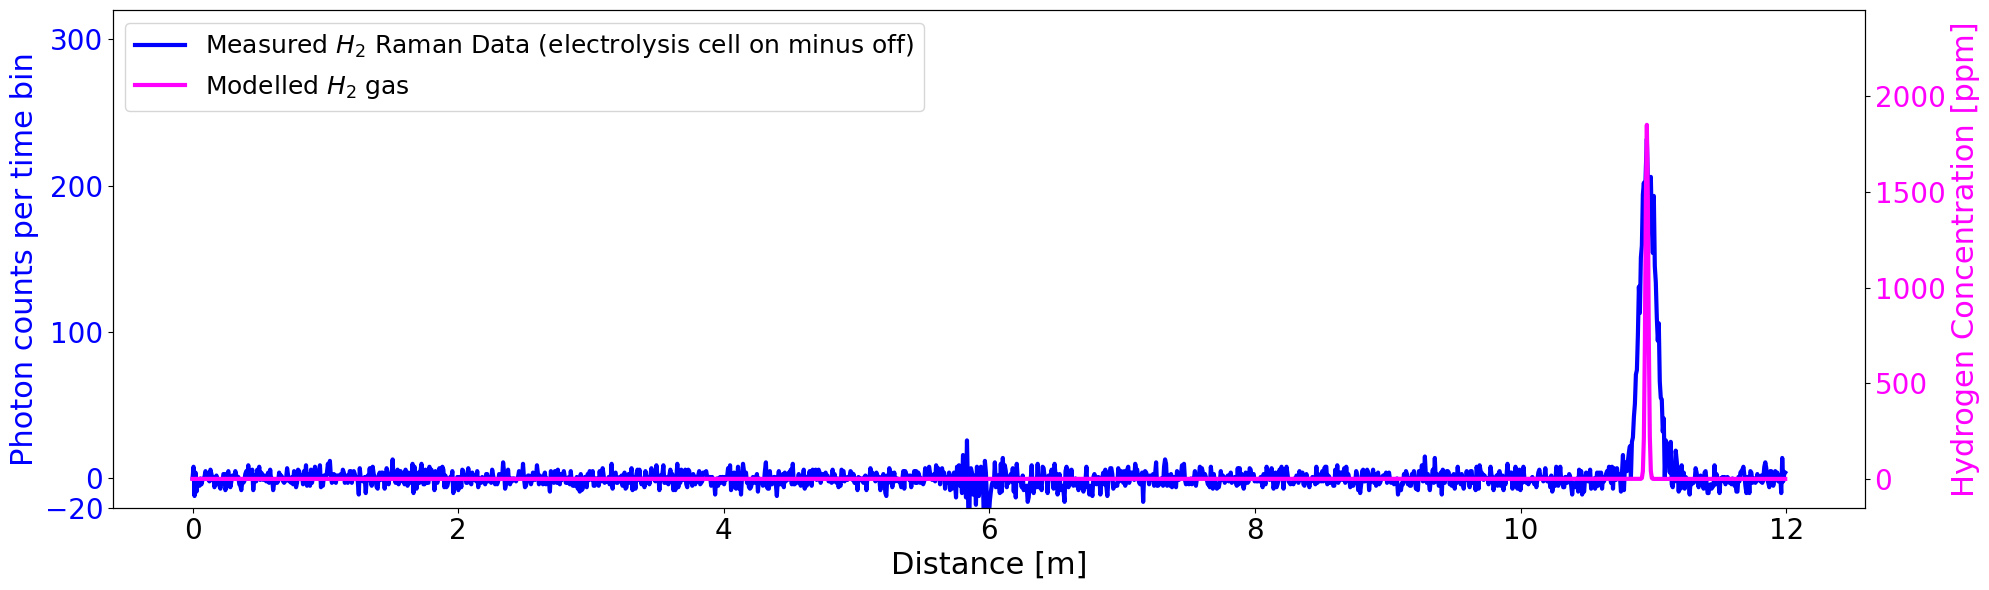

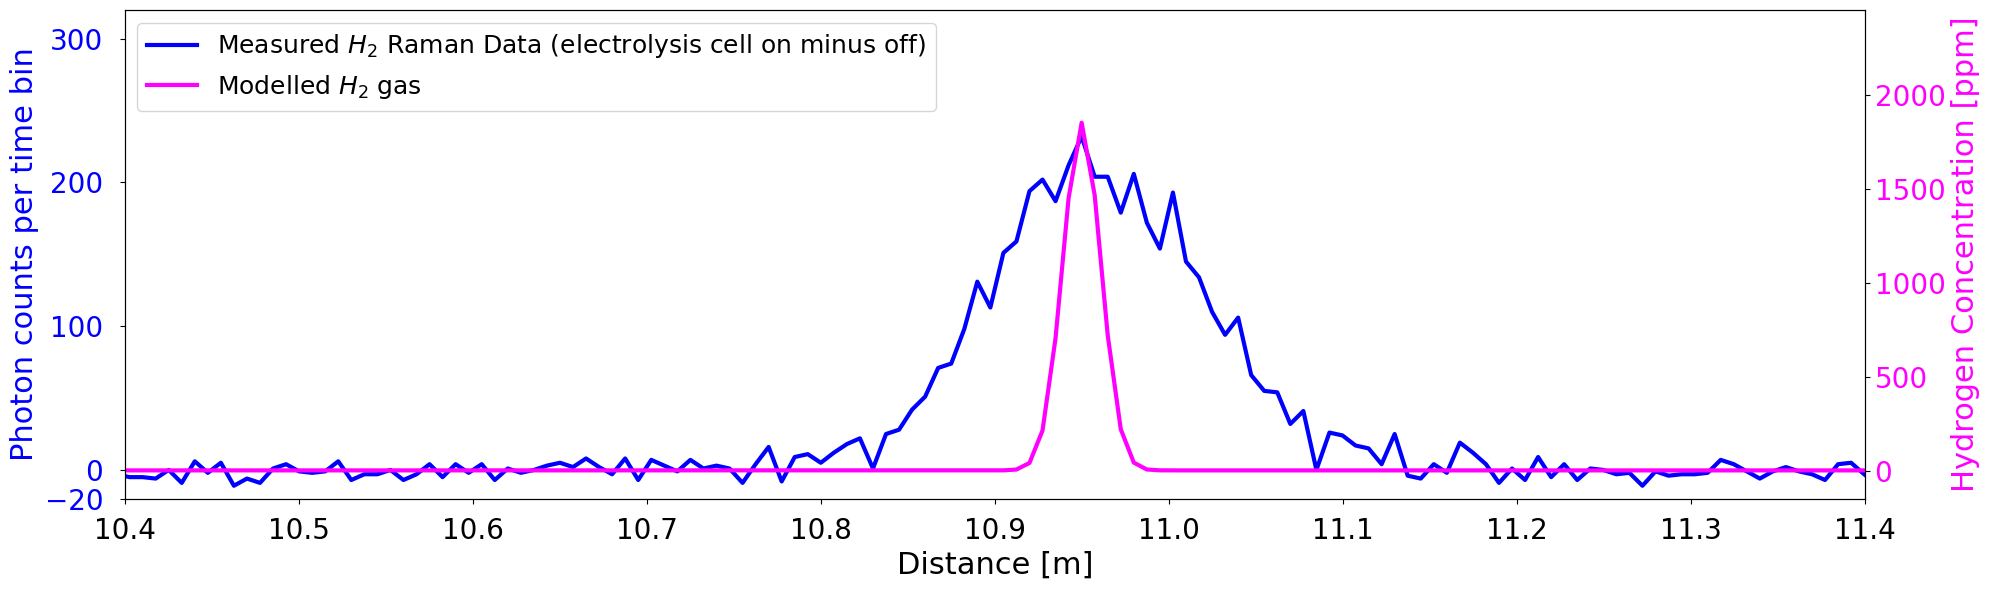

In [ ]:
# --------------------------
# Plot measured pure H2 (H2 - no H2) Raman data VS modelled gas cloud
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Measured $H_2$ Raman Data & Modelled $H_2$ Gas Cloud", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per time bin', color='blue', fontsize=22)
ax1.plot(H2_Raman['Distance'], H2_Raman['H2_minus_noH2'], color='blue', linewidth=3, label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)")
ax1.set_ylim(-20, 320)  # set y-axis limits
ax1.set_yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Hydrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.plot(distance_z, Gas_conc_percent_H2*1e4, color='magenta', linewidth=3, label=f"Modelled $H_2$ gas")
ax2.set_ylim(-150, 2450)  # set y-axis limits
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Plot measured pure H2 (H2 - no H2) Raman data VS modelled gas cloud (Zoomed in to 10.4–11.4 m)
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Measured $H_2$ Raman Data & Modelled $H_2$ Gas Cloud (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per time bin', color='blue', fontsize=22)
ax1.plot(H2_Raman['Distance'], H2_Raman['H2_minus_noH2'], color='blue', linewidth=3, label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)")
ax1.set_xlim(10.4, 11.4)  # set x-axis limits
ax1.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax1.set_ylim(-20, 320)  # set y-axis limits
ax1.set_yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20, pad=12)
ax1.tick_params(axis='x', labelsize=20, pad=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Hydrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.plot(distance_z, Gas_conc_percent_H2*1e4, color='magenta', linewidth=3, label=f"Modelled $H_2$ gas")
ax2.set_xlim(10.4, 11.4)  # set x-axis limits
ax2.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax2.set_ylim(-150, 2450)  # set y-axis limits
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()

## Independent plot

Measured H2 Electrolysis Cell On minus Off: max 232 @ 10.950 m


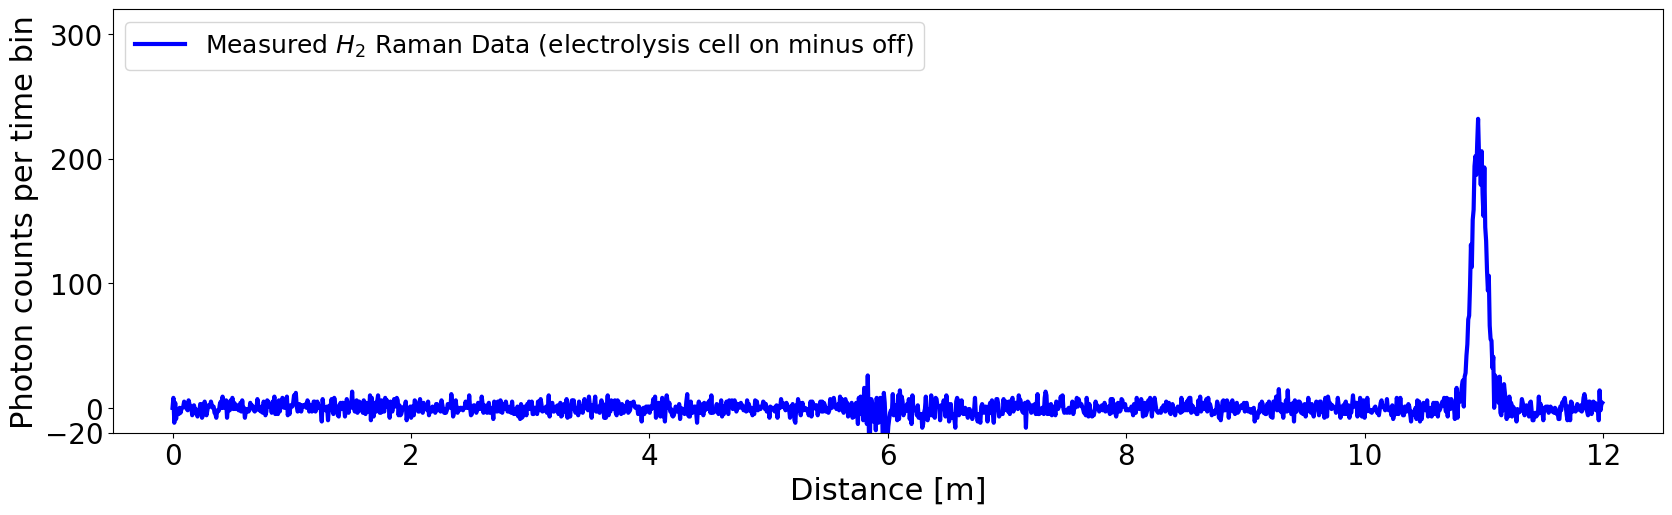

Modelled H2 Raman: max 228 @ 10.950 m


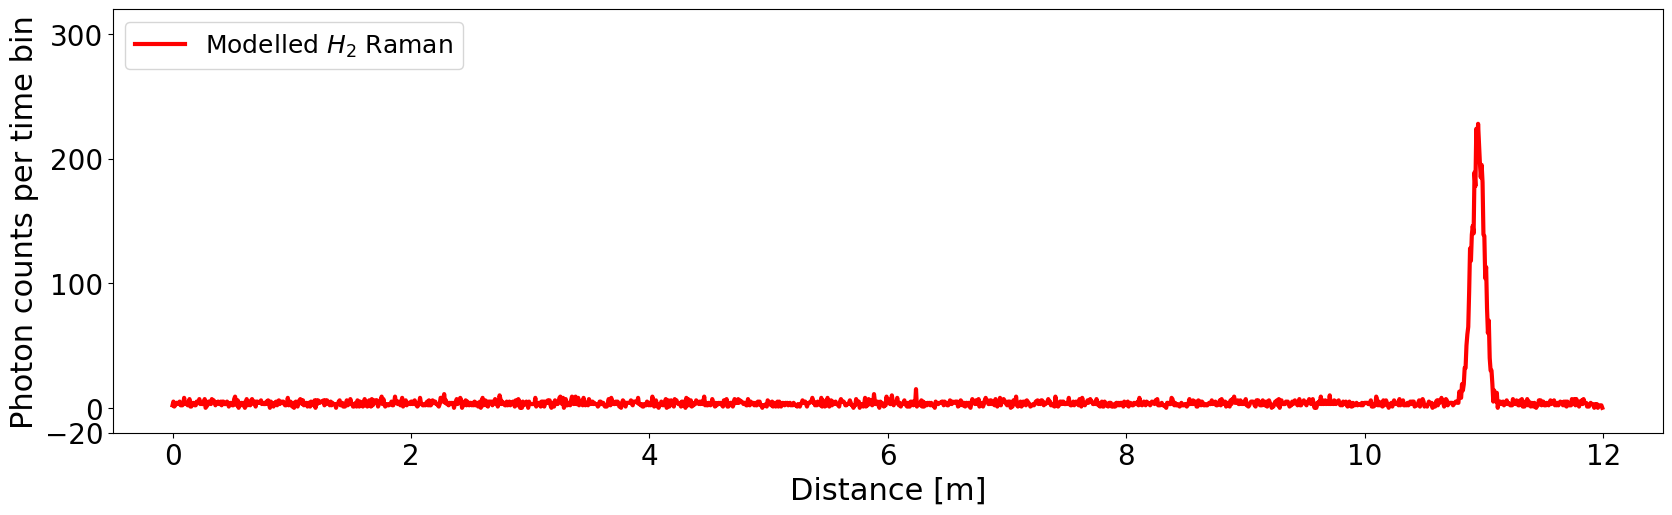

In [ ]:
# --------------------------
# Measured pure H2 (H2 - no H2) Raman Data
# --------------------------
print(f"Measured H2 Electrolysis Cell On minus Off: max {peak_pure_H2:.0f} @ {z_peak_pure_H2:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Measured $H_2$ Raman Channel Data with Electrolysis Cell On minus Off", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2_minus_noH2'],
    color='blue',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(-0.5, 12.5)  # set x-axis limits
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()


# --------------------------
# Modelled H2 Raman Data
# --------------------------
peak_H2_model = max(H2_signal_spread)
# Find index of the maximum photon count
idx_model_max = np.argmax(H2_signal_spread)
z_model_max = distance_z[idx_model_max]
print(f"Modelled H2 Raman: max {peak_H2_model:.0f} @ {z_model_max:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Modelled $H_2$ Raman Data", fontsize=26, pad=15)
plt.plot(
    distance_z,
    H2_signal_spread,
    color='red',
    linewidth=3,
    label=f"Modelled $H_2$ Raman"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(-0.5, 12.5)  # set x-axis limits
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

Measured H2 Electrolysis Cell On minus Off: max 232 @ 10.950 m


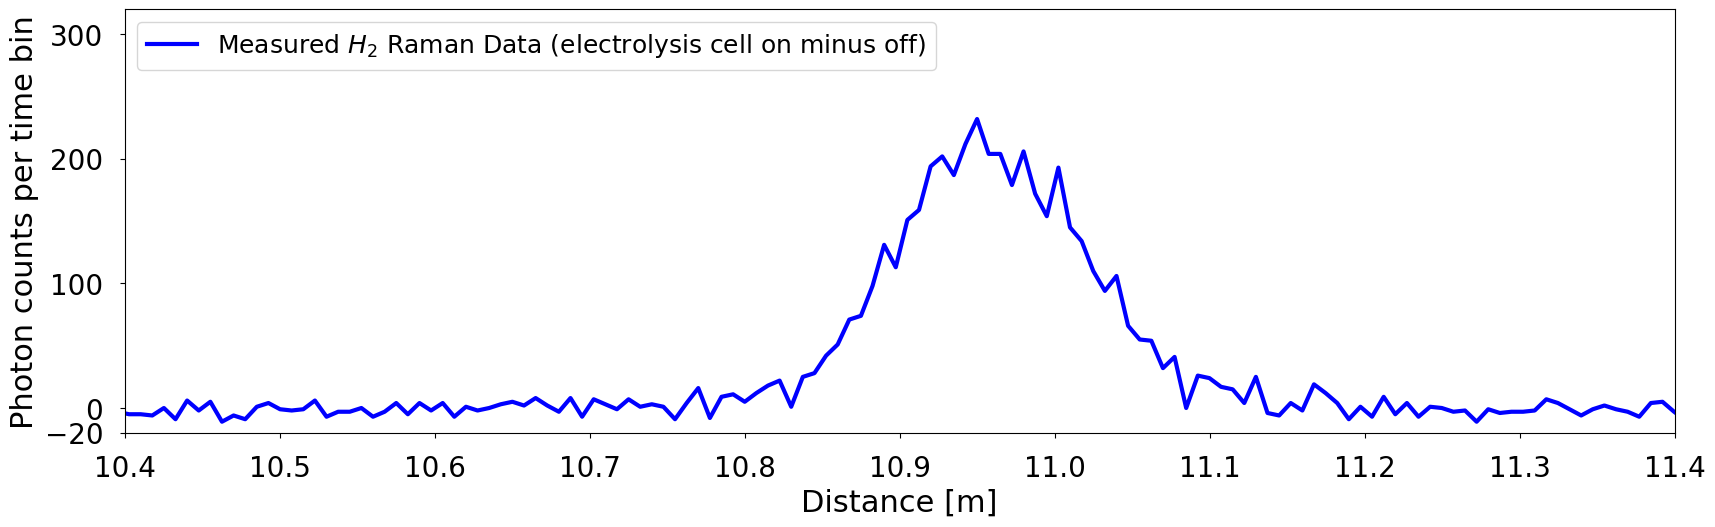

Modelled H2 Raman: max 228 @ 10.950 m


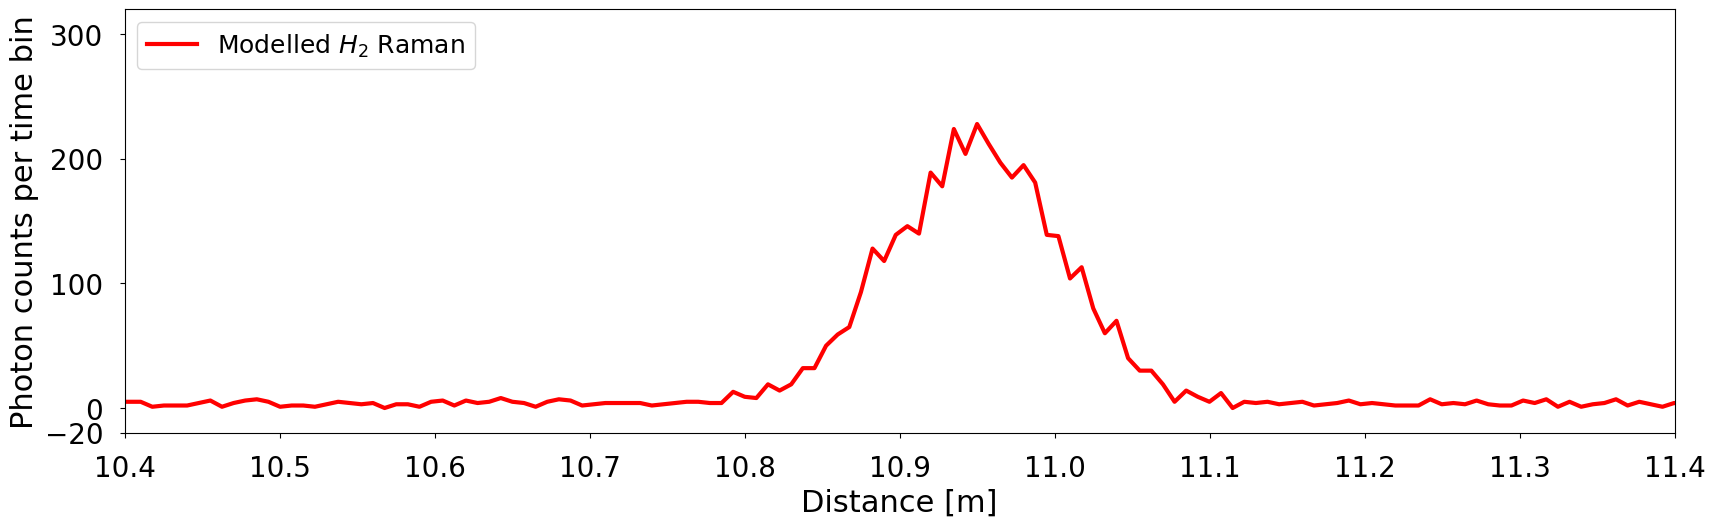

In [ ]:
# --------------------------
# Measured pure H2 (H2 - no H2) Raman Data (Zoomed in to 10.4–11.4 m)
# --------------------------
print(f"Measured H2 Electrolysis Cell On minus Off: max {peak_pure_H2:.0f} @ {z_peak_pure_H2:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Measured $H_2$ Raman Channel Data with Electrolysis Cell On minus Off (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2_minus_noH2'],
    color='blue',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20, pad=12)
plt.legend(loc='upper left', fontsize=18)
plt.show()


# --------------------------
# Modelled H2 Raman Data (Zoomed in to 10.4–11.4 m)
# --------------------------
peak_H2_model = max(H2_signal_spread)
# Find index of the maximum photon count
idx_model_max = np.argmax(H2_signal_spread)
z_model_max = distance_z[idx_model_max]
print(f"Modelled H2 Raman: max {peak_H2_model:.0f} @ {z_model_max:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Modelled $H_2$ Raman Data (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)
plt.plot(
    distance_z,
    H2_signal_spread,
    color='red',
    linewidth=3,
    label=f"Modelled $H_2$ Raman"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20, pad=12)
plt.legend(loc='upper left', fontsize=18)
plt.show()

## Overlay plot ($H_2$ - $no$ $H_2$)

Measured H2 Electrolysis Cell On minus Off: max 232 @ 10.950 m
Modelled H2 Raman (interpolated): max 228 @ 10.950 m


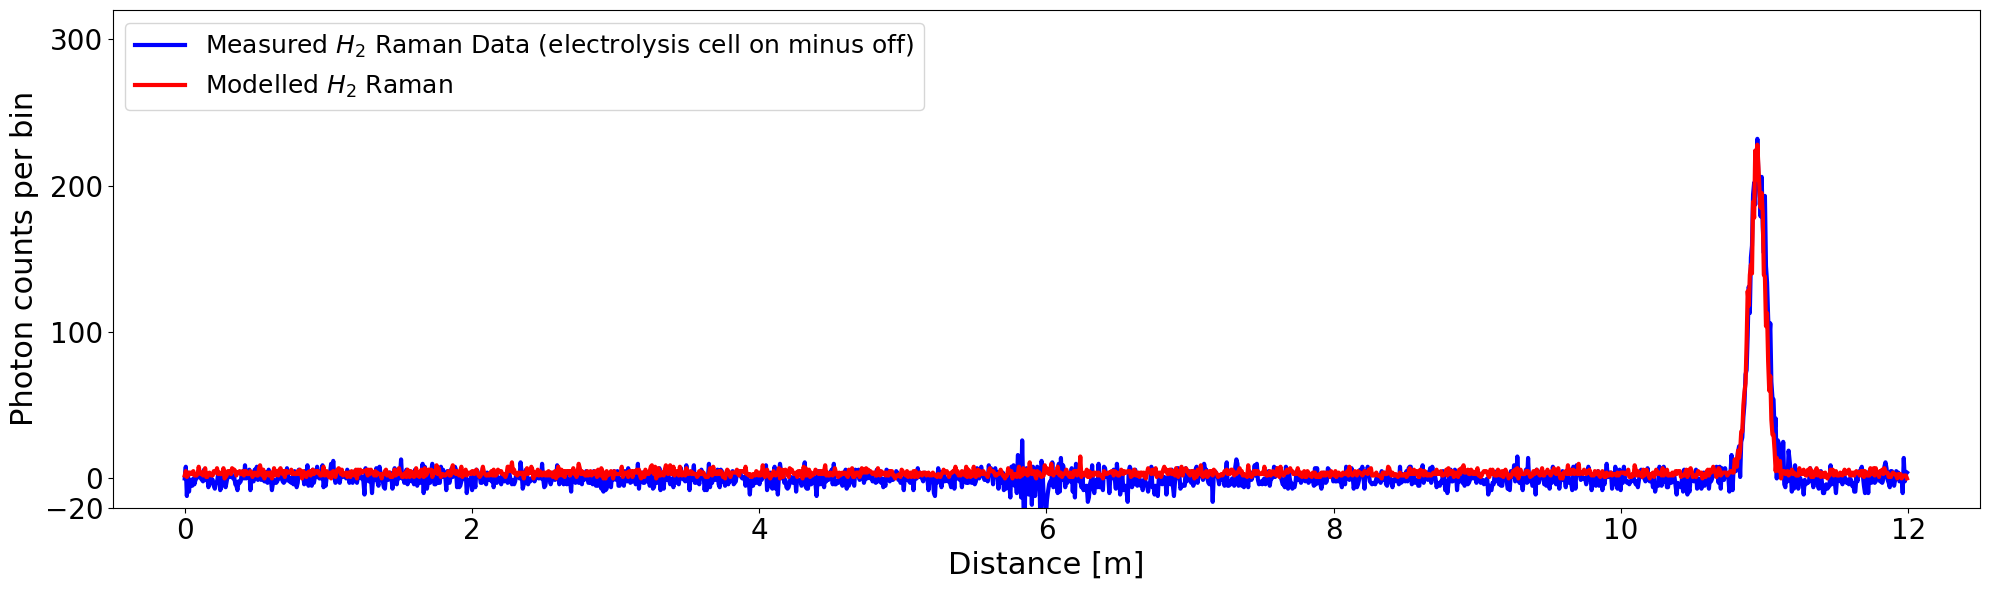

Measured H2 Electrolysis Cell On minus Off: max 232 @ 10.950 m
Modelled H2 Raman (interpolated): max 228 @ 10.950 m


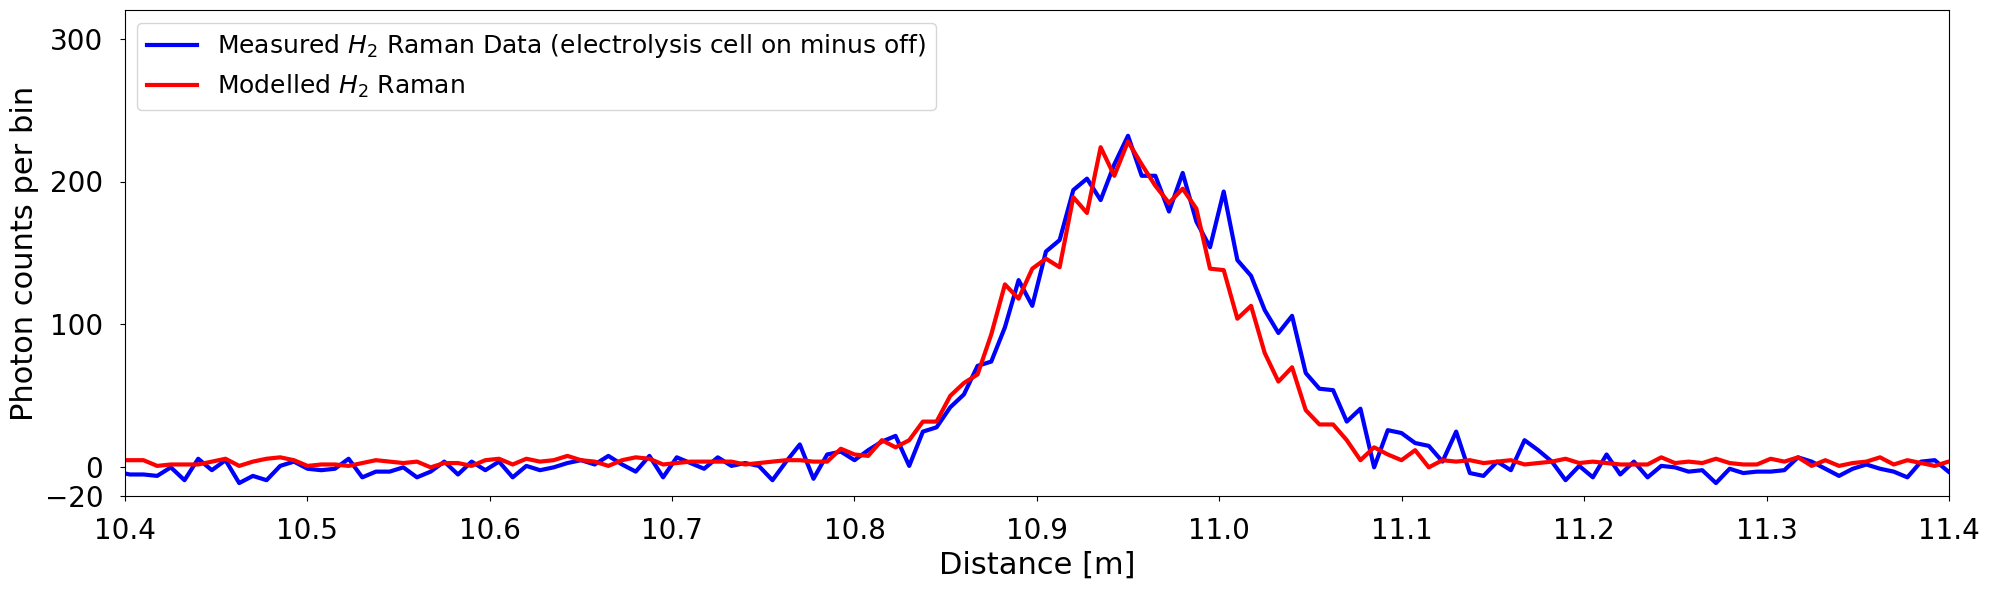

In [ ]:
# ==========================================================
# Overlay of Modelled and Measured H2 Raman Data
# ==========================================================

# Interpolate modelled data to match measured distance grid
# (Ensures both datasets share the same x-axis spacing for direct comparison)
H2_signal_interp = np.interp(H2_Raman['Distance'], distance_z, H2_signal_spread)

# --------------------------
# Combined overlay plot
# --------------------------
plt.figure(figsize = (20, 6))
#plt.title("Overlay of Measured and Modelled $H_2$ Raman Data", fontsize=26, pad=15)

# --- Plot measured data (H2) ---
# Blue curve = experimental Raman signal (H2 - no H2)
print(f"Measured H2 Electrolysis Cell On minus Off: max {peak_pure_H2:.0f} @ {z_peak_pure_H2:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2_minus_noH2'],
    color='blue',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)"
)

# --- Plot modelled data ---
# Red curve = simulated Raman response (interpolated to measured distances)
peak_H2_model_interp = np.nanmax(H2_signal_interp)
# Find index of the maximum photon count
idx_model_interp_max = np.nanargmax(H2_signal_interp)
z_model_interp_max = H2_Raman['Distance'].iloc[idx_model_interp_max]
print(f"Modelled H2 Raman (interpolated): max {peak_H2_model_interp:.0f} @ {z_model_interp_max:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    H2_signal_interp,
    color='red',
    linewidth=3,
    label=f"Modelled $H_2$ Raman"
)

# --- Shared axes and appearance ---
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per bin', fontsize=22)
plt.xlim(-0.5, 12.5)  # set x-axis limits
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Combined overlay plot (Zoomed in to 10.4-11.4 m)
# --------------------------
plt.figure(figsize = (20, 6))
#plt.title("Overlay of Measured and Modelled $H_2$ Raman Data (Zoomed in to 10.4-11.4 m)", fontsize=26, pad=15)

# --- Plot measured data (H2) ---
# Blue curve = experimental Raman signal (H2 - no H2)
print(f"Measured H2 Electrolysis Cell On minus Off: max {peak_pure_H2:.0f} @ {z_peak_pure_H2:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    H2_Raman['H2_minus_noH2'],
    color='blue',
    linewidth=3,
    label=f"Measured $H_2$ Raman Data (electrolysis cell on minus off)"
)

# --- Plot modelled data ---
# Red curve = simulated Raman response (interpolated to measured distances)
peak_H2_model_interp = np.nanmax(H2_signal_interp)
# Find index of the maximum photon count
idx_model_interp_max = np.nanargmax(H2_signal_interp)
z_model_interp_max = H2_Raman['Distance'].iloc[idx_model_interp_max]
print(f"Modelled H2 Raman (interpolated): max {peak_H2_model_interp:.0f} @ {z_model_interp_max:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    H2_signal_interp,
    color='red',
    linewidth=3,
    label=f"Modelled $H_2$ Raman"
)

# --- Shared axes and appearance ---
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-20, 320)  # set y-axis limits
plt.yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20, pad=12)
plt.legend(loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------------
# Export zoomed-in model data (figure range)
# ---------------------------------------

# Select only the distance range shown in the plot
mask = (distance_z >= 10.5) & (distance_z <= 12.0)

df_model_zoom = pd.DataFrame({
    'Distance_m': distance_z[mask],
    'H2_Raman_Model_counts': H2_signal_spread[mask]
})

# Save cropped model data
df_model_zoom.to_csv(
    'modelled_H2_Raman_profile_10p4_to_11p4m.csv',
    index=False
)

print("modelled_H2_Raman_profile_10p4_to_11p4m.csv")

modelled_H2_Raman_profile_10p4_to_11p4m.csv


## Limit of Detection (LOD) - H2

**Signal-to-Noise Ratio (SNR) and Limit of Detection (LOD)**

The signal-to-noise ratio (SNR) and limit of detection (LOD) were evaluated directly from the measured Raman data using the following assumptions:

*   The **signal region** is defined as a spatial window of width $2\Delta z$ centred at the peak H$_2$ Raman response, located at $z = z_\mathrm{peak}$.
*   The **noise region** is selected from a signal-free background region where no hydrogen plume contribution is present.
*   The background noise is assumed to be stationary and Gaussian distributed.

The signal amplitude $A_\mathrm{sig}$ is defined as

$$A_\mathrm{sig} = S_\mathrm{peak} - \mu_\mathrm{noise}$$

where $S_\mathrm{peak}$ is the maximum photon count within the signal region and $\mu_\mathrm{noise}$ is the mean photon count within the noise region.

The noise standard deviation $\sigma_\mathrm{noise}$ is calculated as

$$\sigma_\mathrm{noise} = \sqrt{ \frac{1}{N - 1} \sum_{i=1}^{N} \left(S_i - \mu_\mathrm{noise}\right)^2}$$

where $S_i$ are the photon counts in the noise region and $N$ is the number of samples.

The signal-to-noise ratio is defined as

$$\mathrm{SNR} = \frac{A_\mathrm{sig}}{\sigma_\mathrm{noise}}$$


The limit of detection (LOD) is defined as three times the noise standard deviation:

$$\mathrm{LOD}_{\mathrm{counts}} = 3 \sigma_\mathrm{noise}$$.

Using a calibration factor relating photon counts to hydrogen concentration, the LOD in concentration units is given by

$$\mathrm{LOD}_{\mathrm{ppm}} = \mathrm{LOD}_{\mathrm{counts}} \times \left( \frac{C_\mathrm{ref}}{A_\mathrm{sig}} \right)$$

where $C_\mathrm{ref}$ is the reference hydrogen concentration corresponding to the measured signal amplitude.

In [ ]:
# ============================================================
# Measured data
# ============================================================
distance_meas = H2_Raman['Distance'].values
signal_measured = H2_Raman['H2_minus_noH2'].values

# ============================================================
# Modelled data
# ============================================================
distance_model = distance_z
signal_model = H2_signal_spread

# ============================================================
# Define signal & noise regions (based on measured distance)
# ============================================================
signal_half_width = 0.05  # m, half-width of signal window

# Signal region centred at measured peak position
signal_mask_meas = (
    (distance_meas >= z_peak_pure_H2 - signal_half_width) &
    (distance_meas <= z_peak_pure_H2 + signal_half_width)
)

# Noise region selected from signal-free background
noise_mask_meas = (
    (distance_meas >= 10.4) &
    (distance_meas <= 10.7)
)

# Apply the same spatial regions to the model grid
signal_mask_model = (
    (distance_model >= z_peak_pure_H2 - signal_half_width) &
    (distance_model <= z_peak_pure_H2 + signal_half_width)
)

noise_mask_model = (
    (distance_model >= 10.4) &
    (distance_model <= 10.7)
)

# ============================================================
# Noise statistics
# ============================================================
noise_values_meas = signal_measured[noise_mask_meas]   # Measured noise samples
noise_mean_meas = np.mean(noise_values_meas)           # Mean background level
noise_std_meas  = np.std(noise_values_meas, ddof=1)    # Noise standard deviation

noise_values_model = signal_model[noise_mask_model]    # Model noise samples
noise_mean_model = np.mean(noise_values_model)
noise_std_model  = np.std(noise_values_model, ddof=1)

# Limit of Detection (LOD) in counts (3σ)
LOD_counts_meas  = 3 * noise_std_meas
LOD_counts_model = 3 * noise_std_model

# ============================================================
# Signal amplitudes
# ============================================================
measured_peak = np.max(signal_measured[signal_mask_meas])  # Measured peak signal
A_meas = measured_peak - noise_mean_meas                   # Measured signal amplitude

model_peak = np.max(signal_model[signal_mask_model])       # Model peak signal
A_model = model_peak - noise_mean_model                    # Model signal amplitude

# Basic sanity checks
if A_meas <= 0:
    raise ValueError(f"Measured amplitude non-positive: {A_meas:.3f}. Check masks/sign.")
if A_model <= 0:
    raise ValueError(f"Model amplitude non-positive: {A_model:.3f}. Check masks/sign.")

# ============================================================
# Signal-to-noise ratio (SNR)
# ============================================================
SNR_measured = A_meas / noise_std_meas
SNR_model    = A_model / noise_std_model

# ============================================================
# Calibration: C_ref = 1850 ppm at max measured photon
# ============================================================
C_ref_ppm = 1850  # ppm, reference H2 concentration

# Conversion factor from counts to ppm (derived from measured peak)
ppm_per_count = C_ref_ppm / A_meas

# LOD expressed in concentration units (ppm)
LOD_ppm_measured = LOD_counts_meas * ppm_per_count
LOD_ppm_model    = LOD_counts_model * ppm_per_count

# Model-equivalent peak concentration (ppm) using measured calibration
C_model_peak_ppm = A_model * ppm_per_count

# ============================================================
# Export: interpolate model onto measured grid and save results
# ============================================================
signal_model_interp = np.interp(distance_meas, distance_model, signal_model)
residuals = signal_measured - signal_model_interp

df_export = pd.DataFrame({
    'Distance_m': distance_meas,
    'Measured_H2_Raman_counts': signal_measured,
    'Modelled_H2_Raman_counts_interp': signal_model_interp,
    'Residuals_counts_meas_minus_model': residuals
})

df_export.to_csv('H2_Raman_measured_model_residuals.csv', index=False)

# ============================================================
# Print summary results
# ============================================================
print("========== SNR & LOD Analysis ==========")

print("\n--- Measured ---")
print(f"Noise mean                 = {noise_mean_meas:.3f} counts")
print(f"Noise σ                    = {noise_std_meas:.3f} counts")
print(f"LOD (3σ)                   = {LOD_counts_meas:.3f} counts")
print(f"Peak                       = {measured_peak:.3f} counts")
print(f"Amplitude (peak-noise)     = {A_meas:.3f} counts")
print(f"SNR                        = {SNR_measured:.2f}")
print(f"LOD (ppm, meas calib)      = {LOD_ppm_measured:.0f} ppm")
print(f"Mesured peak (ppm)         = {C_ref_ppm:.0f} ppm")

print("\n--- Model ---")
print(f"Noise mean                 = {noise_mean_model:.3f} counts")
print(f"Noise σ                    = {noise_std_model:.3f} counts")
print(f"LOD (3σ)                   = {LOD_counts_model:.3f} counts")
print(f"Peak                       = {model_peak:.3f} counts")
print(f"Amplitude (peak-noise)     = {A_model:.3f} counts")
print(f"SNR                        = {SNR_model:.2f}")
print(f"LOD (ppm, meas calib)      = {LOD_ppm_model:.0f} ppm")
print(f"Model peak (ppm equiv)     = {C_model_peak_ppm:.0f} ppm")

print("\nExported: H2_Raman_measured_model_residuals.csv")

========== SNR & LOD Analysis ==========

--- Measured ---
Noise mean                 = -1.075 counts
Noise σ                    = 4.979 counts
LOD (3σ)                   = 14.937 counts
Peak                       = 232.000 counts
Amplitude (peak-noise)     = 233.075 counts
SNR                        = 46.81
LOD (ppm, meas calib)      = 119 ppm
Mesured peak (ppm)         = 1850 ppm

--- Model ---
Noise mean                 = 3.700 counts
Noise σ                    = 2.028 counts
LOD (3σ)                   = 6.084 counts
Peak                       = 228.000 counts
Amplitude (peak-noise)     = 224.300 counts
SNR                        = 110.60
LOD (ppm, meas calib)      = 48 ppm
Model peak (ppm equiv)     = 1780 ppm

Exported: H2_Raman_measured_model_residuals.csv


In [ ]:
print("\n========== SNR & LOD Analysis ==========\n")

# Column widths (adjust if you want)
w_q = 45   # Quantity column width
w_m = 15   # Measured column width
w_md = 15  # Model column width

# Header
header = f"{'Quantity':<{w_q}}{'Measured':<{w_m}}{'Model':<{w_md}}"
print(header)
print("-" * (w_q + w_m + w_md))

# Rows
rows = [
    ("Noise mean [counts]",                         f"{noise_mean_meas:.3f}",  f"{noise_mean_model:.3f}"),
    ("Noise σ [counts]",                            f"{noise_std_meas:.3f}",   f"{noise_std_model:.3f}"),
    ("LOD (3σ) [counts]",                           f"{LOD_counts_meas:.3f}",  f"{LOD_counts_model:.3f}"),
    ("Peak signal [counts]",                        f"{measured_peak:.3f}",    f"{model_peak:.3f}"),
    ("Signal amplitude (peak - noise) [counts]",    f"{A_meas:.3f}",           f"{A_model:.3f}"),
    ("SNR",                                         f"{SNR_measured:.2f}",     f"{SNR_model:.2f}"),
    ("LOD (ppm, measured calibration)",             f"{LOD_ppm_measured:.0f}", f"{LOD_ppm_model:.0f}"),
    ("Peak concentration [ppm]",                    f"{C_ref_ppm:.0f}",        f"{C_model_peak_ppm:.0f}")
]

for q, meas, mod in rows:
    print(f"{q:<{w_q}}{meas:<{w_m}}{mod:<{w_md}}")


========== SNR & LOD Analysis ==========

Quantity                                     Measured       Model          
---------------------------------------------------------------------------
Noise mean [counts]                          -1.075         3.700          
Noise σ [counts]                             4.979          2.028          
LOD (3σ) [counts]                            14.937         6.084          
Peak signal [counts]                         232.000        228.000        
Signal amplitude (peak - noise) [counts]     233.075        224.300        
SNR                                          46.81          110.60         
LOD (ppm, measured calibration)              119            48             
Peak concentration [ppm]                     1850           1780           


# Section 9-2 Comparison of Measured and Modelled $N_2$ Raman

## Measured $N_2$ Data
---
C(H2) = 1700-2000ppm @ 10.950m - GasDog, 10mins
> 260108-C(H2) Raman,10m,10mins (Andrew).csv

### Plot the $N_2$ data

In [ ]:
# --------------------------
# Measured N2 data (Raman Lidar)
# --------------------------
# Load measured data from Google Drive (in Google Colab) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# URL to measured data file on Dropbox
URL_Measured_Raman = 'https://www.dropbox.com/scl/fi/6z2sjrsr7e43yv1froxkt/260108-C-H2-Raman-10m-10mins-Andrew.csv?rlkey=x336mebfnbhhruvuh4rukqyxq&st=29bw6f01&raw=1'  # Remember to replace dl = 0 with raw = 1
# Read CSV, skip first row (header info)
H2_Raman = pd.read_csv(URL_Measured_Raman)

# # Mount Google Drive
# drive.mount('/content/drive')
# # Path to CSV (adjust your filename accordingly)
# csv_path = '/content/drive/My Drive/Colab Notebooks/2 H2 Raman Lidar Results/250404-Data,Real H2%/260108-C(H2) Raman,10m,10mins (Andrew).csv'
# # Load the CSV file
# H2_Raman = pd.read_csv(csv_path)


# --------------------------
# Printing & Plotting
# --------------------------
# Display the first few rows
print(H2_Raman.head())

# Create the plot
import plotly.graph_objects as go

f1 = go.Figure(
    data = [
        go.Scatter(x=H2_Raman['Distance'], y=H2_Raman['N2'], name='N₂ at 11.351 m', mode='lines', line=dict(color='orange'))
    ],
    layout = {'xaxis': {'title': 'Distance (m)'}, 'yaxis': {'title': 'Photon counts per time bin'}, 'title': 'Comparison N2 at 11.351 m'}
)
# Format y-axis to show 3 decimal places
f1.update_xaxes(tickformat=".3f")
f1.show()

   Distance  no_H2    H2   N2
0  0.000000    7.0   7.0  1.0
1  0.007495    4.0  12.0  0.0
2  0.014990   17.0   5.0  1.0
3  0.022484    8.0  12.0  2.0
4  0.029979   14.0   5.0  1.0


#### $N_2$ data

Measured N2: max 28543 @ 10.935 m (within 8–12 m)


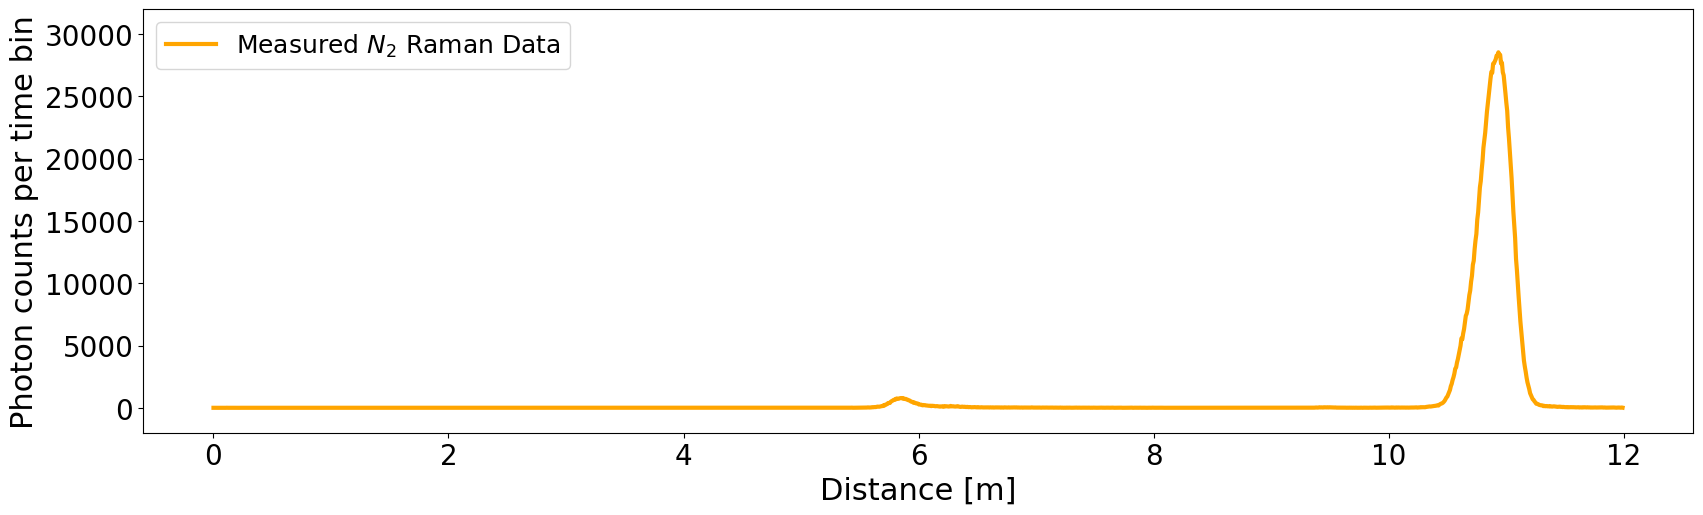

In [ ]:
# --------------------------
# Compute N2 peak in 8–12 m range
# --------------------------
# Filter data between 8 and 12 m
subset = H2_Raman[(H2_Raman['Distance'] >= 8) & (H2_Raman['Distance'] <= 12)]

# Calculate max value in that range
peak_N2 = subset['N2'].max()

# Find the distance where that maximum occurs
z_peak_N2 = subset.loc[subset['N2'].idxmax(), 'Distance']

print(f"Measured N2: max {peak_N2:.0f} @ {z_peak_N2:.3f} m (within 8–12 m)")


# --------------------------
# Matplotlib static plot
# --------------------------
plt.figure(figsize = (20, 5.5))
#plt.title("Measured $N_2$ Raman Channel Data", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['N2'],
    color='orange',
    linewidth=3,
    label=f"Measured $N_2$ Raman Data"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

## Independent plot

Measured N2 Electrolysis Cell On minus Off: max 28543 @ 10.935 m


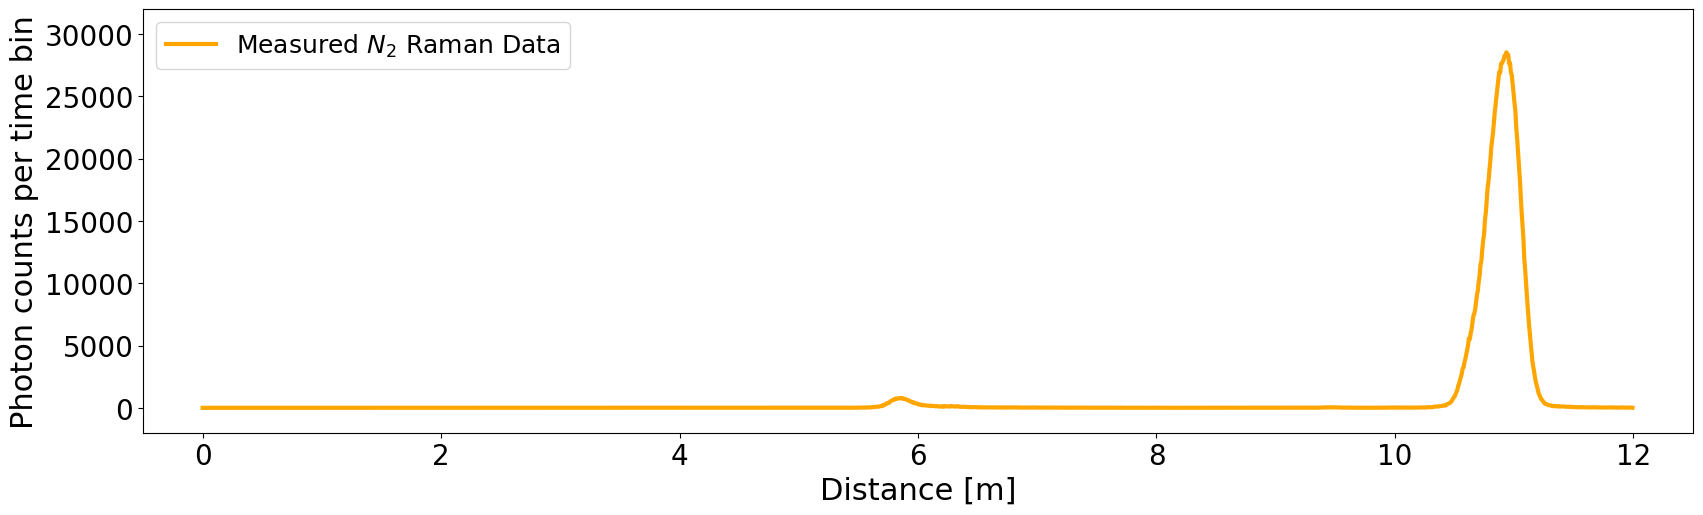

Modelled N2 Raman: max 28574 @ 10.882 m


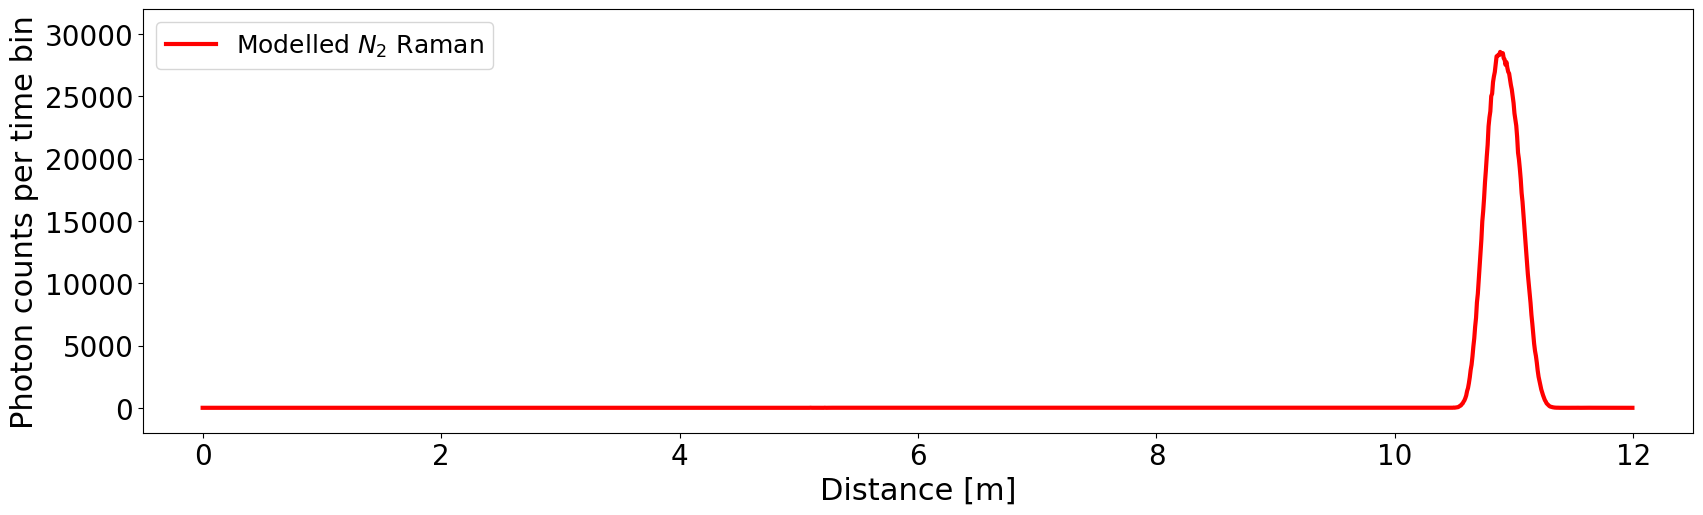

In [ ]:
# --------------------------
# Measured N2 Raman Data
# --------------------------
print(f"Measured N2 Electrolysis Cell On minus Off: max {peak_N2:.0f} @ {z_peak_N2:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Measured $N_2$ Raman Channel", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['N2'],
    color='orange',
    linewidth=3,
    label=f"Measured $N_2$ Raman Data"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(-0.5, 12.5)  # set x-axis limits
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()


# --------------------------
# Modelled N2 Raman Data
# --------------------------
peak_N2_model = max(N2_signal_spread)
# Find index of the maximum photon count
idx_model_max = np.argmax(N2_signal_spread)
z_model_max = distance_z[idx_model_max]
print(f"Modelled N2 Raman: max {peak_N2_model:.0f} @ {z_model_max:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Modelled $N_2$ Raman Data", fontsize=26, pad=15)
plt.plot(
    distance_z,
    N2_signal_spread,
    color='red',
    linewidth=3,
    label=f"Modelled $N_2$ Raman"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(-0.5, 12.5)  # set x-axis limits
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

Measured N2: max 28543 @ 10.935 m


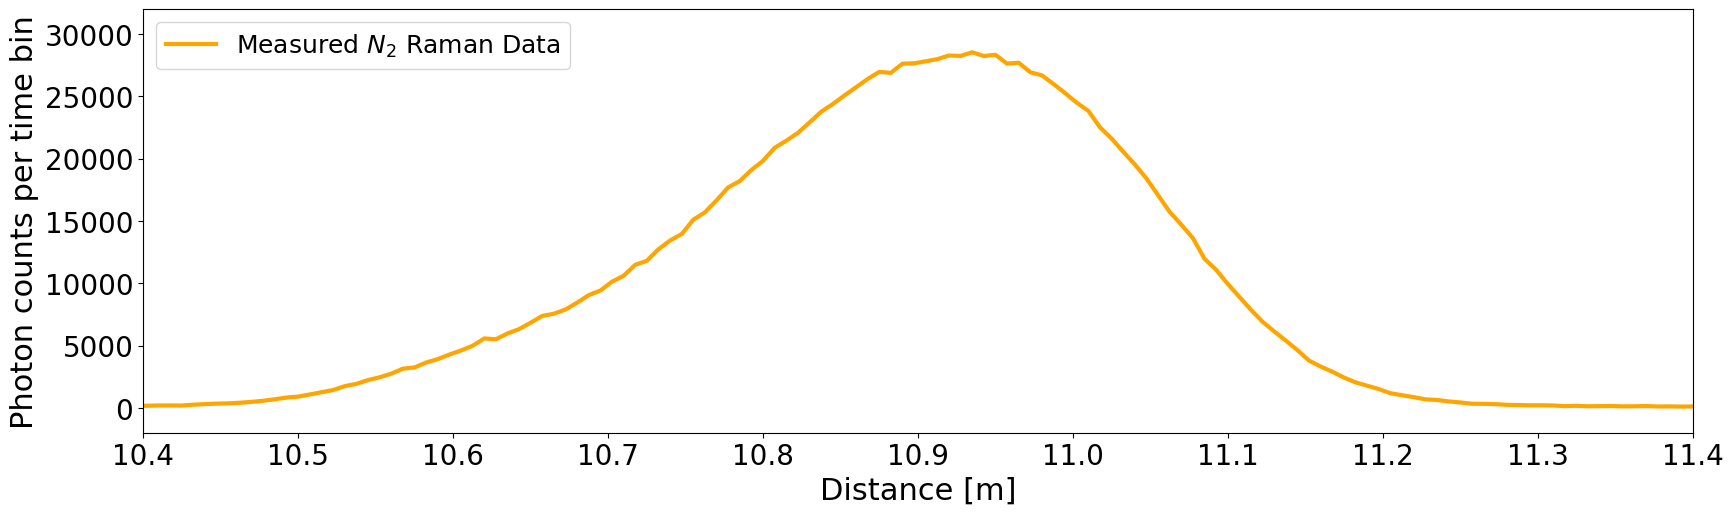

Modelled N2 Raman: max 28574 @ 10.882 m


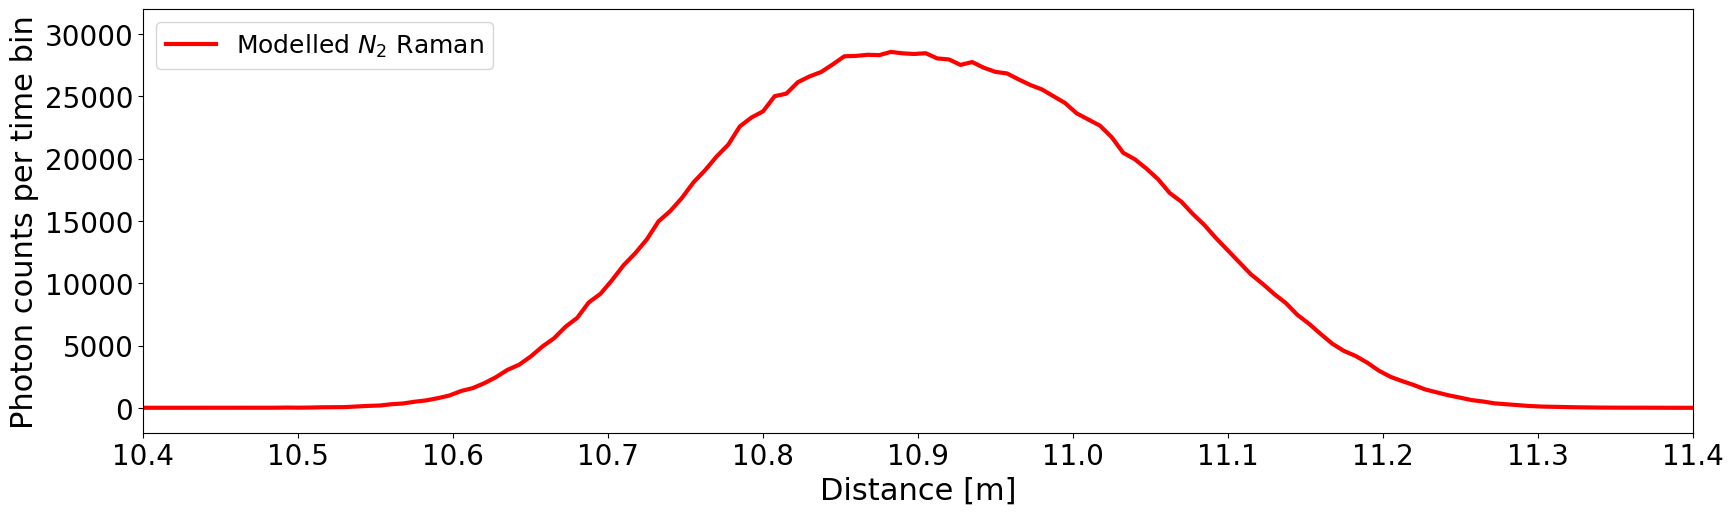

In [ ]:
# --------------------------
# Measured N2 Raman Data (Zoomed in to 10.4–11.4 m)
# --------------------------
print(f"Measured N2: max {peak_N2:.0f} @ {z_peak_N2:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Measured $N_2$ Raman Channel Data (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)
plt.plot(
    H2_Raman['Distance'],
    H2_Raman['N2'],
    color='orange',
    linewidth=3,
    label=f"Measured $N_2$ Raman Data"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()


# --------------------------
# Modelled N2 Raman Data (Zoomed in to 10.4–11.4 m)
# --------------------------
peak_N2_model = max(N2_signal_spread)
# Find index of the maximum photon count
idx_model_max = np.argmax(N2_signal_spread)
z_model_max = distance_z[idx_model_max]
print(f"Modelled N2 Raman: max {peak_N2_model:.0f} @ {z_model_max:.3f} m")

plt.figure(figsize = (20, 5.5))
#plt.title("Modelled $N_2$ Raman Data (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)
plt.plot(
    distance_z,
    N2_signal_spread,
    color='red',
    linewidth=3,
    label=f"Modelled $N_2$ Raman"
)
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per time bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

## Overlay plot ($N_2$)

Measured N2: max 28543 @ 10.935 m
Modelled N2 Raman (interpolated): max 28574 @ 10.882 m


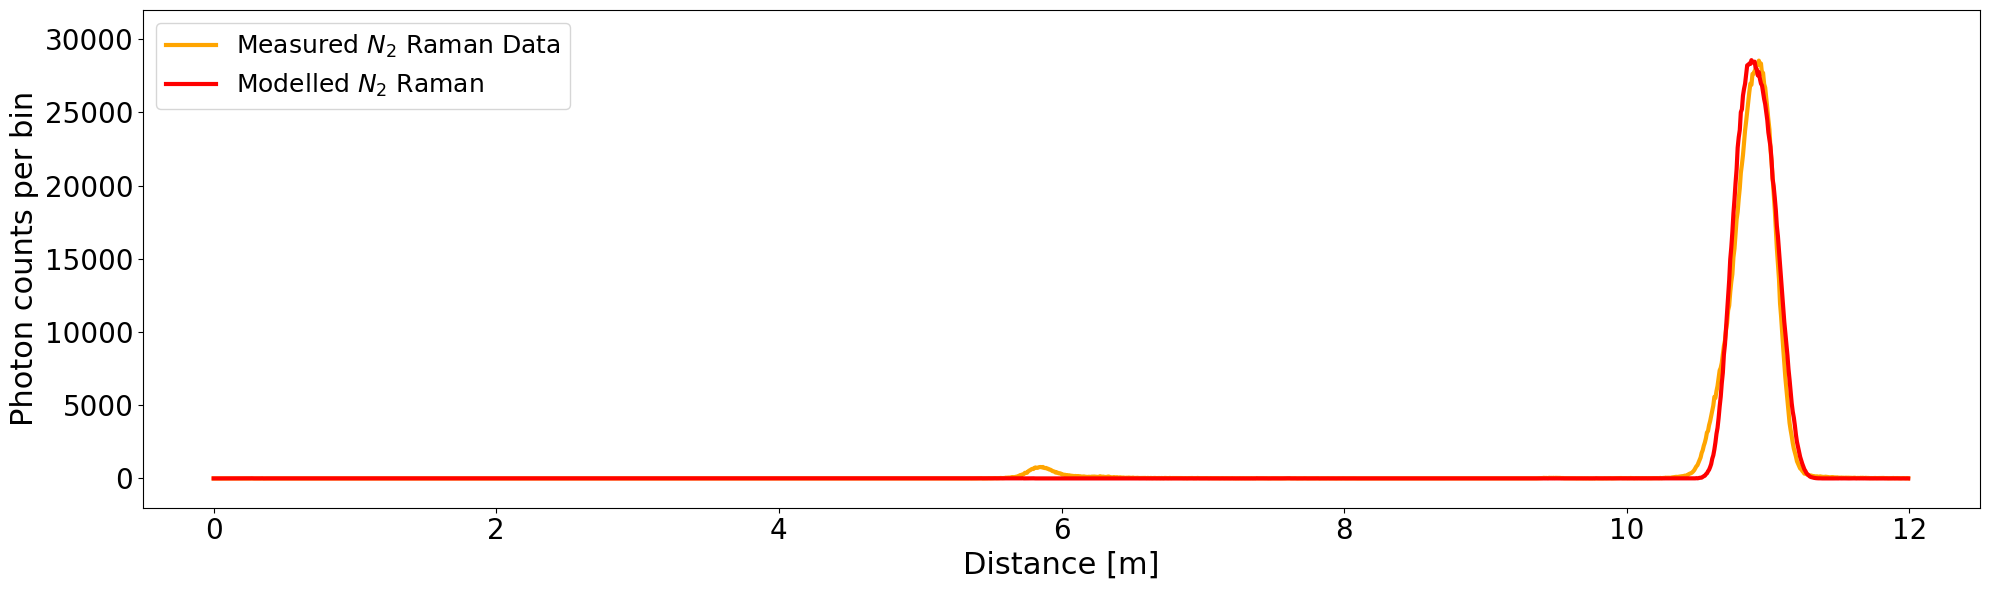

Measured N2: max 28543 @ 10.935 m
Modelled N2 Raman (interpolated): max 28574 @ 10.882 m


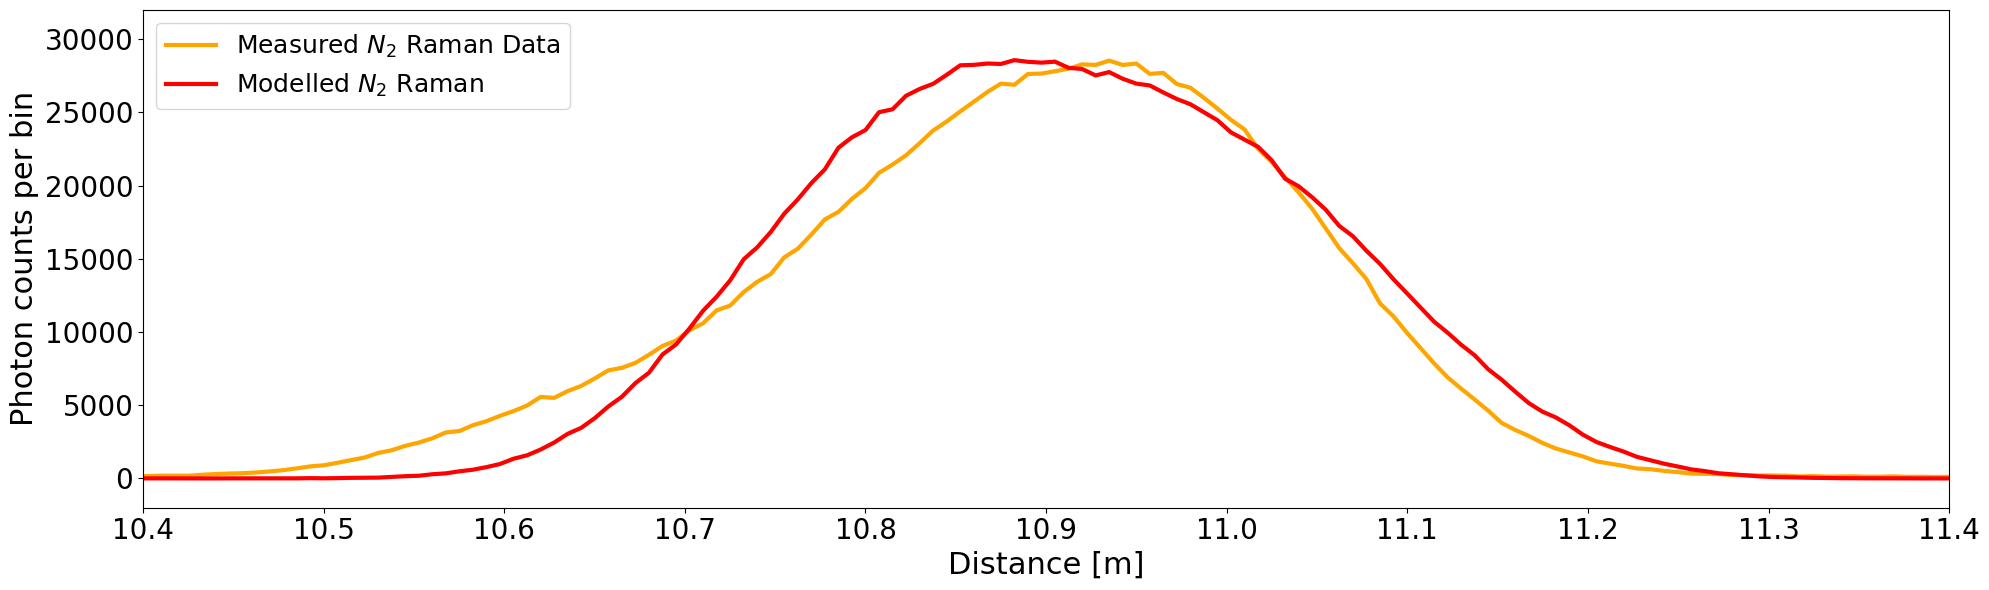

In [ ]:
# ==========================================================
# Overlay of Modelled and Measured N2 Raman Data
# ==========================================================

# Interpolate modelled data to match measured distance grid
# (Ensures both datasets share the same x-axis spacing for direct comparison)
N2_signal_interp = np.interp(H2_Raman['Distance'], distance_z, N2_signal_spread)

# --------------------------
# Combined overlay plot
# --------------------------
plt.figure(figsize = (20, 6))
#plt.title("Overlay of Measured and Modelled $N_2$ Raman Data", fontsize=26, pad=15)

# --- Plot measured data (N2) ---
# Blue curve = experimental Raman signal (N2)
print(f"Measured N2: max {peak_N2:.0f} @ {z_peak_N2:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    H2_Raman['N2'],
    color='orange',
    linewidth=3,
    label=f"Measured $N_2$ Raman Data"
)

# --- Plot modelled data ---
# Red curve = simulated Raman response (interpolated to measured distances)
peak_N2_model_interp = np.nanmax(N2_signal_interp)
# Find index of the maximum photon count
idx_model_interp_max = np.nanargmax(N2_signal_interp)
z_model_interp_max = H2_Raman['Distance'].iloc[idx_model_interp_max]
print(f"Modelled N2 Raman (interpolated): max {peak_N2_model_interp:.0f} @ {z_model_interp_max:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    N2_signal_interp,
    color='red',
    linewidth=3,
    label=f"Modelled $N_2$ Raman"
)

# --- Shared axes and appearance ---
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per bin', fontsize=22)
plt.xlim(-0.5, 12.5)  # set x-axis limits
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Combined overlay plot (Zoomed in to 10.4–11.4 m)
# --------------------------
plt.figure(figsize = (20, 6))
#plt.title("Overlay of Measured and Modelled $N_2$ Raman Data (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)

# --- Plot measured data (N2) ---
# Blue curve = experimental Raman signal (N2)
print(f"Measured N2: max {peak_N2:.0f} @ {z_peak_N2:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    H2_Raman['N2'],
    color='orange',
    linewidth=3,
    label=f"Measured $N_2$ Raman Data"
)

# --- Plot modelled data ---
# Red curve = simulated Raman response (interpolated to measured distances)
peak_N2_model_interp = np.nanmax(N2_signal_interp)
# Find index of the maximum photon count
idx_model_interp_max = np.nanargmax(N2_signal_interp)
z_model_interp_max = H2_Raman['Distance'].iloc[idx_model_interp_max]
print(f"Modelled N2 Raman (interpolated): max {peak_N2_model_interp:.0f} @ {z_model_interp_max:.3f} m")

plt.plot(
    H2_Raman['Distance'],
    N2_signal_interp,
    color='red',
    linewidth=3,
    label=f"Modelled $N_2$ Raman"
)

# --- Shared axes and appearance ---
plt.xlabel('Distance [m]', fontsize=22)
plt.ylabel('Photon counts per bin', fontsize=22)
plt.xlim(10.4, 11.4)  # set x-axis limits
plt.xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
plt.ylim(-2000, 32000)  # set y-axis limits
plt.yticks(np.arange(0, 32000, 5000))  # set y-tick marks
plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()